# Auckland2025 SailGP Data Analysis Technical Challenge

**Overview**
This notebook analyses data from the Auckland Sail GP event in 2025
The task states a minimum of 3 questions must be completed. However I will attempt as many as I can.



In [190]:
#Importing all neccesary libraries 

# Data Manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# XML Parsing
import xml.etree.ElementTree as ET

# Geospatial Libraries
from shapely.geometry import Point, LineString
from pyproj import Transformer

# Math and OS utilities
import math
import glob
import os

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# SHAP for model explainability
import shap
shap.initjs()

# IPython Display (for notebook outputs)
from IPython.display import display, HTML


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## **Question 1: Calculating the Circular Mean of Wind Direction**  

For this question, I:  
- Built a function to calculate the **circular mean**, ensuring correct averaging of compass directions.  
- Used **circular statistics** instead of an arithmetic mean, as wind direction is a circular variable.  
- Analysed wind direction data from the **Course Marks dataset**, focusing on **Mark 1** for the full day.  
- Downsampled the wind readings into **5-minute, 1-minute, and 10-second intervals** for comparison.  
- Displayed the **10-second interval wind direction** on a graph, alongside the **overall 10-second circular mean** for the day.  

This approach provides an accurate representation of wind behavior while handling circular data correctly.  

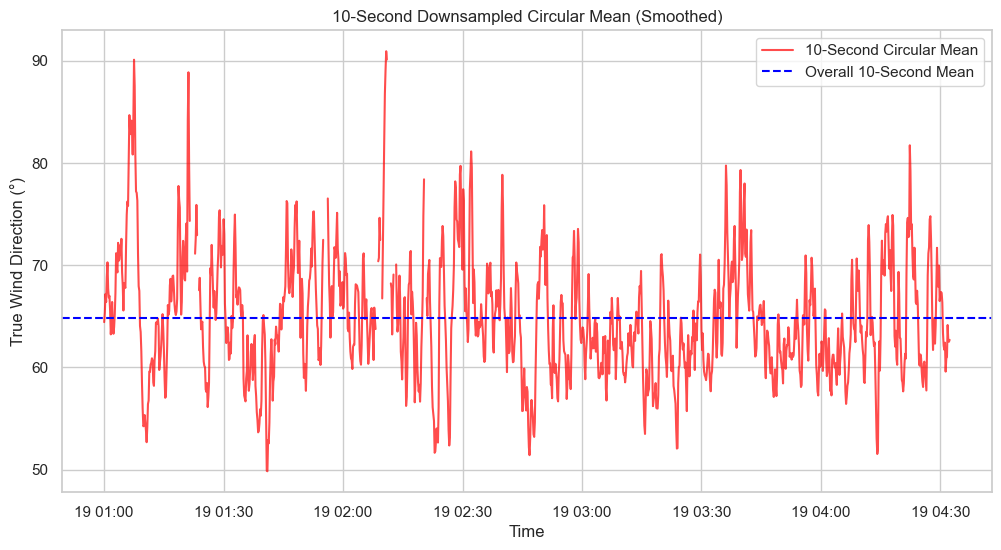

Circular Mean for the day at M1 (1-Minute): 64.99 degrees
Circular Mean for the day at M1 (5-Minute): 64.82 degrees
Circular Mean for the day at M1 (10-Second): 64.79 degrees
Circular Standard Deviation (1-Minute): 5.50 degrees
Circular Standard Deviation (5-Minute): 3.50 degrees
Circular Standard Deviation (10-Second): 5.96 degrees


In [191]:
#Question 1
# Function to compute the circular mean of an array of angles (in degrees)
# The circular mean is calculated by converting angles to radians, 
# computing the mean sine and cosine values, then converting back to degrees.
# This ensures proper averaging of directional data, preventing issues with 360° wraparound.
def circular_mean(angles_deg):
    """
    Computes the circular mean of angles in degrees.
    Converts to radians, finds mean sine & cosine, and returns result in degrees.
    """
    angles_rad = np.deg2rad(angles_deg)
    sin_mean = np.mean(np.sin(angles_rad))
    cos_mean = np.mean(np.cos(angles_rad))
    mean_angle_rad = np.arctan2(sin_mean, cos_mean)
    return np.rad2deg(mean_angle_rad) % 360

#I also calculated the Standard Deviation to understand the variability of the wind direction for the day
# Function to compute circular standard deviation

def circular_std(angles_deg):
    """
    Computes circular standard deviation to measure variability in angular data.
    """
    angles_rad = np.deg2rad(angles_deg)
    sin_mean = np.mean(np.sin(angles_rad))
    cos_mean = np.mean(np.cos(angles_rad))
    R = np.sqrt(sin_mean**2 + cos_mean**2)
    return np.rad2deg(np.sqrt(-2 * np.log(R)))

# Load the coure marks dataset dataset using date time as the index for downsampling
file_path = 'Data/Course_Marks_2025-01-19.csv'
df = pd.read_csv(file_path, parse_dates=['DATETIME'])
df = df.set_index('DATETIME')

# Filter for Mark 1 (M1) 
df_mark1 = df[df['MARK'] == 'M1']

# Downsampling: 1-minute intervals
df_1min = df_mark1.resample('1min').agg({'TWD_deg': circular_mean})
df_1min['circular_std'] = df_mark1.resample('1min')['TWD_deg'].apply(circular_std)

# Downsampling: 5-minute intervals
df_5min = df_mark1.resample('5min').agg({'TWD_deg': circular_mean})
df_5min['circular_std'] = df_mark1.resample('5min')['TWD_deg'].apply(circular_std)

# Downsampling: 10-second intervals
df_10sec = df_mark1.resample('10s').agg({'TWD_deg': circular_mean})
df_10sec['circular_std'] = df_mark1.resample('10s')['TWD_deg'].apply(circular_std)

# Compute overall mean wind direction for 10-second intervals for plotting on the graph
mean_10sec_value = circular_mean(df_10sec['TWD_deg'])

# Plot: 10-second downsampled circular means with smoothing and average line
plt.figure(figsize=(12, 6))
plt.plot(df_10sec.index, df_10sec['TWD_deg'], linestyle='-', color='red', alpha=0.7, label='10-Second Circular Mean')
plt.axhline(mean_10sec_value, color='blue', linestyle='--', label='Overall 10-Second Mean')
plt.xlabel('Time')
plt.ylabel('True Wind Direction (°)')
plt.title('10-Second Downsampled Circular Mean (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

# Print results
mean_1min, std_1min = circular_mean(df_1min['TWD_deg']), circular_std(df_1min['TWD_deg'])
mean_5min, std_5min = circular_mean(df_5min['TWD_deg']), circular_std(df_5min['TWD_deg'])
mean_10sec, std_10sec = circular_mean(df_10sec['TWD_deg']), circular_std(df_10sec['TWD_deg'])

print(f"Circular Mean for the day at M1 (1-Minute): {mean_1min:.2f} degrees")
print(f"Circular Mean for the day at M1 (5-Minute): {mean_5min:.2f} degrees")
print(f"Circular Mean for the day at M1 (10-Second): {mean_10sec:.2f} degrees")
print(f"Circular Standard Deviation (1-Minute): {std_1min:.2f} degrees")
print(f"Circular Standard Deviation (5-Minute): {std_5min:.2f} degrees")
print(f"Circular Standard Deviation (10-Second): {std_10sec:.2f} degrees")


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### **Results & Interpretation**  

The computed circular means and standard deviations for different time intervals at **Mark 1** are:  

#### **Circular Mean (Average Wind Direction)**
- **10-Second Mean:** **64.79°**  
- **1-Minute Mean:** **64.99°**  
- **5-Minute Mean:** **64.82°**  

#### **Circular Standard Deviation (Wind Direction Variability)**
- **10-Second Std Dev:** **5.96°**  
- **1-Minute Std Dev:** **5.50°**  
- **5-Minute Std Dev:** **3.50°**  

#### **Key Observations:**
The **mean wind direction remains consistent** across different time intervals (~64.8°).  
The **standard deviation decreases** as the interval length increases, meaning wind direction fluctuates more at higher frequencies but smooths out over time.  
The **graph displays 10-second interval wind direction**, with a **blue dashed line showing the overall mean** for reference.  
The **5-minute interval** has the lowest standard deviation (**3.50°**), confirming that wind direction stabilises when viewed over longer periods.  



-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### **Question 2: Calculating VMC from Boat GPS Data and Course XML**  

#### **Objective:**  
Calculate the **Velocity Made Good (VMC)** for a boat using a course XML file and a timeseries of GPS positions.

#### **For this question I:**  
1. **Extract Course Marks:**  
   - Read the course XML file and identified **Mark 1 (M1)** and the **Leeward Gate (LG1 & LG2)**.  
   - Calculated the **midpoint of LG1 and LG2** as the target for VMC calculations.  

2. **Compute Course Bearing:**  
   - Found the **bearing from M1 to the LG1 midpoint**, which defines the ideal sailing direction.  

3. **Load Boat Data:**  
   - Loaded **AUS boat GPS data** and filtered for **Leg 2 (M1 → LG1 Midpoint)** in Race 1.  

4. **Calculate Speed and Heading:**  
   - Used **Haversine formula** to compute the **distance** between GPS points.  
   - Calculated **boat speed** and **heading** for each recorded time.  

5. **Compute VMC:**  
   - Measured the **angle difference** between the boat’s heading and the course bearing.  
   - Applied the formula:  
     ```
     VMC = Boat Speed × cos(Heading - Course Bearing)
     ```
   - Converted VMC into **m/s and km/h**.  

6. **Output Results:**  
   - Printed the **average VMC** for Leg 2.  
   - Displayed **VMC values for each timestamp** in Leg 2.  


In [192]:
# I am analysing VMC on leg 2 of the first race from M1 to the midpoint of LG1 and LG2.

# Parse the race 1 XML file 
tree = ET.parse('Data/25011905_03-13-55.xml')
root = tree.getroot()

# Extract compound marks from the course XML, keeping gates as separate points
compound_marks = {}

# Dictionary to group gates correctly
gate_marks = {'LG1': []}  # LG1 is a gate, so I need to group it.

# Loop through course marks
for compound in root.find('Course').findall('CompoundMark'):
    compound_name = compound.attrib.get('Name')
    
    # Identify LG1 as a gate
    if compound_name.startswith('LG'):
        if compound_name not in gate_marks:
            gate_marks[compound_name] = []
    
    # Extract mark coordinates
    marks = [(float(mark.attrib.get('TargetLat')), float(mark.attrib.get('TargetLng')), mark.attrib.get('Name')) 
             for mark in compound.findall('Mark')]

    # Store LG1 as a gate, I could store the other gates as gates but for simplicity and because I am only using LG1 and M1 I just stored LG1
    if compound_name in gate_marks:
        gate_marks[compound_name].extend(marks)
    else:
        compound_marks[compound_name] = marks

# Extract M1 mark coordinates 
m1_marks = compound_marks.get("M1", [])
if not m1_marks:
    raise ValueError("M1 mark not found in the course data.")

# Extract latitude and longitude from M1, 
m1_lat, m1_lon, _ = m1_marks[0]  
print("Mark 1 Coordinates:", m1_marks)
# Extract LG1 and LG2 marks and compute their midpoint
lg1_marks = gate_marks.get("LG1", [])
if len(lg1_marks) < 2:
    raise ValueError("LG1 gate does not have both LG1 and LG2 marks.")
lg1_mid_lat = (lg1_marks[0][0] + lg1_marks[1][0]) / 2
lg1_mid_lon = (lg1_marks[0][1] + lg1_marks[1][1]) / 2
print("Leeward gate midpoint:", (lg1_mid_lat, lg1_mid_lon))
# Compute course bearing from M1 to LG1 midpoint
course_bearing = calculate_bearing(m1_lat, m1_lon, lg1_mid_lat, lg1_mid_lon)
print("course bearing:", course_bearing)
# Load AUS boat data
# Filtering for the first race and leg 2 (M1 to LG1 gate midpoint)
boat_df = pd.read_csv('Data/data_AUS.csv', parse_dates=['DATETIME'])
leg2_df = boat_df[(boat_df['TRK_LEG_NUM_unk'] == 2) & (boat_df['TRK_RACE_NUM_unk'] == 25011905)].copy()

# function to compute distance, boat speed, and heading using Lat/Lon values
def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return 6371 * 2 * np.arcsin(np.sqrt(a)) * 1000  # Convert km to meters

leg2_df['prev_LAT'], leg2_df['prev_LON'] = leg2_df['LATITUDE_GPS_unk'].shift(1), leg2_df['LONGITUDE_GPS_unk'].shift(1)
leg2_df['time_diff_sec'] = leg2_df['DATETIME'].diff().dt.total_seconds()
leg2_df['distance_m'] = leg2_df.apply(lambda row: haversine_distance(row['prev_LAT'], row['prev_LON'], row['LATITUDE_GPS_unk'], row['LONGITUDE_GPS_unk']) if pd.notnull(row['prev_LAT']) else np.nan, axis=1)
leg2_df['boat_speed_m_s'] = leg2_df['distance_m'] / leg2_df['time_diff_sec']

# Compute boat heading
leg2_df['boat_heading'] = leg2_df.apply(lambda row: calculate_bearing(row['prev_LAT'], row['prev_LON'], row['LATITUDE_GPS_unk'], row['LONGITUDE_GPS_unk']) if pd.notnull(row['prev_LAT']) else np.nan, axis=1)

# Compute angle difference between boat heading and course bearing
leg2_df['delta_angle'] = leg2_df['boat_heading'].apply(lambda h: angle_diff(h, course_bearing) if pd.notnull(h) else np.nan)

# Compute VMC
leg2_df['VMC_m_s'] = leg2_df['boat_speed_m_s'] * np.cos(np.deg2rad(leg2_df['delta_angle']))

# Drop NaNs and compute the average VMC
# Remove rows where the leg number does not match expected Leg 2
plot_df = leg2_df[(leg2_df['TRK_LEG_NUM_unk'] == 2)].dropna(subset=['VMC_m_s'])
avg_vmc = plot_df['VMC_m_s'].mean()
avg_vmc_kmh = avg_vmc * 3.6  # Convert from m/s to km/h
print(f"Average VMC for leg 2 (M1 to LG1 midpoint): {avg_vmc:.2f} m/s ({avg_vmc_kmh:.2f} km/h)")

# Display VMC values for leg 2
# Display all computed VMC values for Leg 2
# These values represent the boat's velocity made good towards the LG1 midpoint
# Each row corresponds to a time step in the dataset where VMC was calculated
print("Start of leg 2")
print("VMC values for Leg 2 (M1 to LG1 midpoint):")
for index, row in plot_df.iterrows():
    datetime_str = row['DATETIME'].strftime('%Y-%m-%d %H:%M:%S')
    vmc = row['VMC_m_s']
    print(f"{datetime_str} - {vmc:.2f} m/s ({vmc * 3.6:.2f} km/h)")
print("End of leg 2")

Mark 1 Coordinates: [(-36.829713, 174.76527, 'M1')]
Leeward gate midpoint: (-36.8338455, 174.7548255)
course bearing: 243.69221165491138
Average VMC for leg 2 (M1 to LG1 midpoint): 17.66 m/s (63.57 km/h)
Start of leg 2
VMC values for Leg 2 (M1 to LG1 midpoint):
2025-01-19 03:08:26 - 29.57 m/s (106.44 km/h)
2025-01-19 03:08:27 - 12.46 m/s (44.87 km/h)
2025-01-19 03:08:28 - 21.36 m/s (76.91 km/h)
2025-01-19 03:08:29 - 21.51 m/s (77.44 km/h)
2025-01-19 03:08:30 - 21.50 m/s (77.40 km/h)
2025-01-19 03:08:31 - 21.30 m/s (76.67 km/h)
2025-01-19 03:08:32 - 21.07 m/s (75.85 km/h)
2025-01-19 03:08:33 - 20.85 m/s (75.05 km/h)
2025-01-19 03:08:34 - 20.40 m/s (73.45 km/h)
2025-01-19 03:08:35 - 19.82 m/s (71.36 km/h)
2025-01-19 03:08:36 - 19.49 m/s (70.17 km/h)
2025-01-19 03:08:37 - 19.30 m/s (69.49 km/h)
2025-01-19 03:08:38 - 19.13 m/s (68.87 km/h)
2025-01-19 03:08:39 - 19.00 m/s (68.40 km/h)
2025-01-19 03:08:40 - 18.99 m/s (68.35 km/h)
2025-01-19 03:08:41 - 19.21 m/s (69.17 km/h)
2025-01-19 03:08:

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### **Results: VMC for Leg 2 Race 1**
- **The distance between M1 and midpoint of LG1 is approx 1.05km which seems accurate**
- **The average VMC for the Austrailian boat on leg2 of the first race is 63.57 km/h**

**End of Question 2** 

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### **Question 3: Verifying Boat Calibration & Proposing Adjusted Wind Data**  

#### **Objective:**  
Verify the calibration of the boats’ wind instruments by comparing their wind speed and direction readings to an external reference source (course marks). If a discrepancy is found, suggest post-calibrated values.  

#### **Methodology:**  

1. **Extract AUS Boat Wind Data (Pre-Race 1):**  
   - Filtered **2-minute** window (03:06:00 - 03:08:00) before Race 1 start where I believe the boats will be positioned close to SL1 course mark 
   - Selected **True Wind Speed (TWS)** and **True Wind Direction (TWD)** from AUS boat data.  

2. **Extract Course Mark Reference Wind Data:**  
   - Used **SL1 course mark** data for the same **2-minute** window.  
   - Extracted and averaged **TWS and TWD** for comparison.  

3. **Compare AUS Boat vs. SL1 Wind Data:**  
   - Calculated the **mean wind speed and direction** for each source.  
   - Evaluated differences in measurements.  

4. **Extend Analysis to All Boats (Race 1 Start):**  
   - Applied the same **2-minute** window to all participating boats.  
   - Computed each boat’s **average TWS and TWD**.  
   - Compared the fleet’s **average wind readings** to SL1.  

5. **Repeat Calibration Check for Race 2 and Race 3 Start:**  
   - Used the **2-minute** window (03:27:00 - 03:29:00) of prestart race 2 and the **2-minute** window (03:48:00 - 03:50:00) of prestart race 3.  
   - Recomputed boat wind readings and compared with SL1 at those prestart times 


In [193]:
#Question 3 
#Function: Compute Circular Mean
def circular_mean(angles):
    """Compute the circular mean of an array of angles (in degrees)."""
    angles_rad = np.deg2rad(angles)
    sin_mean = np.mean(np.sin(angles_rad))
    cos_mean = np.mean(np.cos(angles_rad))
    mean_rad = np.arctan2(sin_mean, cos_mean)
    return np.rad2deg(mean_rad) % 360

# Load and Filter AUS Boat Data (Prestart Race 1)
#I know that the race started at 03:08:00 from the course xml so I just subtracted two mins from that.
start_time = pd.Timestamp("2025-01-19 03:06:00", tz='UTC')
end_time   = pd.Timestamp("2025-01-19 03:08:00", tz='UTC')

boat_df = pd.read_csv('Data/data_AUS.csv', parse_dates=['DATETIME'])
boat_df['DATETIME'] = pd.to_datetime(boat_df['DATETIME'], dayfirst=True, utc=True)

aus_filtered = boat_df[(boat_df['DATETIME'] >= start_time) & (boat_df['DATETIME'] <= end_time)]

# Compute mean wind speed and direction for AUS
aus_mean_tws = aus_filtered['TWS_SGP_km_h_1'].mean()
aus_mean_twd = circular_mean(aus_filtered['TWD_SGP_deg'])

# Load and Filter SL1 Course Mark Data
mark_df = pd.read_csv('Data/Course_Marks_2025-01-19.csv', parse_dates=['DATETIME'])
mark_df['DATETIME'] = pd.to_datetime(mark_df['DATETIME'], utc=True)

sl1_filtered = mark_df[(mark_df['DATETIME'] >= start_time) & 
                        (mark_df['DATETIME'] <= end_time) & 
                        (mark_df['MARK'] == 'SL1')]

# Compute mean wind speed and direction for SL1
sl1_mean_tws = sl1_filtered['TWS_km_h_1'].mean()
sl1_mean_twd = circular_mean(sl1_filtered['TWD_deg'])

# Display Results
print(f"\n### Wind Data Comparison - AUS vs SL1 (Prestart Race 1) ###")
print(f"Time Window: {start_time} to {end_time}")
print(f"- AUS Wind Speed: {aus_mean_tws:.2f} km/h")
print(f"- AUS Wind Direction: {aus_mean_twd:.2f}°")
print(f"- SL1 Wind Speed: {sl1_mean_tws:.2f} km/h")
print(f"- SL1 Wind Direction: {sl1_mean_twd:.2f}°")

diff_tws = aus_mean_tws - sl1_mean_tws
diff_twd = aus_mean_twd - sl1_mean_twd
print(f"\nDifference in Wind Speed: {diff_tws:.2f} km/h")
print(f"Difference in Wind Direction: {diff_twd:.2f}°")


### Wind Data Comparison - AUS vs SL1 (Prestart Race 1) ###
Time Window: 2025-01-19 03:06:00+00:00 to 2025-01-19 03:08:00+00:00
- AUS Wind Speed: 38.80 km/h
- AUS Wind Direction: 57.34°
- SL1 Wind Speed: 29.07 km/h
- SL1 Wind Direction: 59.20°

Difference in Wind Speed: 9.74 km/h
Difference in Wind Direction: -1.86°


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## **Initial Observations: AUS vs SL1 (Prestart Race 1)**  

Comparing the wind data from the AUS boat to the SL1 course mark, we see:  
- **Wind speed difference:** AUS reports **9.74 km/h higher** than SL1.  
- **Wind direction difference:** AUS reports wind **1.86° further left** than SL1.  

This suggests that the AUS boat's wind instruments are consistently reading **higher wind speeds** and **a slightly offset wind direction.**  
Before making conclusions, I will check if this pattern holds across **all boats** during Prestart Race 1.

In [194]:
#Prestart race 1 on all boats 
# Load & Process Fleet Wind Data (Prestart Race 1)
teams = ["BRA", "DEN", "ESP", "GBR", "GER", "ITA", "NZL", "SUI", "USA", "AUS"] #Canada did not race 
results = []

for team in teams:
    file_path = f'Data/data_{team}.csv'
    try:
        boat_df = pd.read_csv(file_path, parse_dates=['DATETIME'])
        boat_df['DATETIME'] = pd.to_datetime(boat_df['DATETIME'], dayfirst=True, utc=True)
        boat_filtered = boat_df[(boat_df['DATETIME'] >= start_time) & (boat_df['DATETIME'] <= end_time)]
        
        if boat_filtered.empty:
            continue
        
        mean_tws = boat_filtered['TWS_SGP_km_h_1'].mean()
        mean_twd = circular_mean(boat_filtered['TWD_SGP_deg'])
        results.append([team, mean_tws, mean_twd])

    except (FileNotFoundError, KeyError):
        continue

# Convert results to DataFrame
fleet_df = pd.DataFrame(results, columns=['Team', 'Mean TWS (km/h)', 'Mean TWD (deg)'])

# Display Results
print(f"\n### Fleet Wind Data - Prestart Race 1 ###")
print(f"Time Window: {start_time} to {end_time}\n")
print(fleet_df)

# Compute Fleet vs SL1 Differences
fleet_mean_tws = fleet_df['Mean TWS (km/h)'].mean()
fleet_mean_twd = circular_mean(fleet_df['Mean TWD (deg)'])

diff_tws = fleet_mean_tws - sl1_mean_tws
diff_twd = fleet_mean_twd - sl1_mean_twd

print(f"\nSL1 Reference: TWS = {sl1_mean_tws:.2f} km/h, TWD = {sl1_mean_twd:.2f}°")
print("Mean TWS of fleet:", fleet_mean_tws)
print("Mean TWD of fleet:", fleet_mean_twd)
print(f"Difference in Mean True Wind Speed: {diff_tws:.2f} km/h")
print(f"Difference in Mean True Wind Direction: {diff_twd:.2f}°")


### Fleet Wind Data - Prestart Race 1 ###
Time Window: 2025-01-19 03:06:00+00:00 to 2025-01-19 03:08:00+00:00

  Team  Mean TWS (km/h)  Mean TWD (deg)
0  BRA        35.599256       60.626031
1  DEN        39.241818       58.524105
2  ESP        36.943417       59.137388
3  GBR        39.267934       62.635385
4  GER        36.266250       60.875438
5  ITA        35.601667       62.359418
6  NZL        39.272562       56.684579
7  SUI        33.579333       62.297690
8  USA        36.436167       65.228970
9  AUS        38.804050       57.335719

SL1 Reference: TWS = 29.07 km/h, TWD = 59.20°
Mean TWS of fleet: 37.10124531680441
Mean TWD of fleet: 60.5703870956283
Difference in Mean True Wind Speed: 8.03 km/h
Difference in Mean True Wind Direction: 1.37°


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## **Fleet-Wide Calibration Check (Prestart Race 1)**  

Analysing the **full fleet** compared to SL1, we find:  
- **Average wind speed across all boats**: **8.03 km/h higher than SL1.**  
- **Average wind direction difference**: **1.37° to the right of SL1.**  

This confirms that the issue is not specific to AUS—**all boats are consistently reading higher wind speeds** than the SL1 course mark.  
- The wind speed difference suggests the instruments may **overestimate wind speed by ~21.64% on average.**  
- The wind direction offset is **minor**.

To determine if this pattern holds, I will now extend the analysis to **all three prestarts.**

In [195]:
#All boats prestart 1 , 2 and 3
# Function to Process Each Prestart

def process_fleet_wind(start_time, end_time, race_label):
    print(f"\n### Fleet Wind Data - {race_label} ###")
    print(f"Time Window: {start_time} to {end_time}\n")

    results = []
    for team in teams:
        file_path = f'Data/data_{team}.csv'
        try:
            boat_df = pd.read_csv(file_path, parse_dates=['DATETIME'])
            boat_df['DATETIME'] = pd.to_datetime(boat_df['DATETIME'], dayfirst=True, utc=True)
            boat_filtered = boat_df[(boat_df['DATETIME'] >= start_time) & (boat_df['DATETIME'] <= end_time)]

            if boat_filtered.empty:
                continue
            
            mean_tws = boat_filtered['TWS_SGP_km_h_1'].mean()
            mean_twd = circular_mean(boat_filtered['TWD_SGP_deg'])
            results.append([team, mean_tws, mean_twd])

        except (FileNotFoundError, KeyError):
            continue

    fleet_df = pd.DataFrame(results, columns=['Team', 'Mean TWS (km/h)', 'Mean TWD (deg)'])
    print(fleet_df)

    # Process SL1 Data
    sl1_filtered = mark_df[(mark_df['DATETIME'] >= start_time) & (mark_df['DATETIME'] <= end_time) & (mark_df['MARK'] == 'SL1')]
    if sl1_filtered.empty:
        print(f"No SL1 wind data available for {race_label}.\n")
        return

    sl1_mean_tws = sl1_filtered['TWS_km_h_1'].mean()
    sl1_mean_twd = circular_mean(sl1_filtered['TWD_deg'])

    # Compute Differences
    fleet_mean_tws = fleet_df['Mean TWS (km/h)'].mean()
    fleet_mean_twd = circular_mean(fleet_df['Mean TWD (deg)'])
    
    diff_tws = fleet_mean_tws - sl1_mean_tws
    diff_twd = fleet_mean_twd - sl1_mean_twd

    print(f"\nSL1 Reference: TWS = {sl1_mean_tws:.2f} km/h, TWD = {sl1_mean_twd:.2f}°")
    print(f"Difference in Mean True Wind Speed: {diff_tws:.2f} km/h")
    print(f"Difference in Mean True Wind Direction: {diff_twd:.2f}°\n")


# Run for All Three Prestarts
#I used the racecoursexml to find each races start time and subtracted two mins to get window
process_fleet_wind(pd.Timestamp("2025-01-19 03:06:00", tz='UTC'), pd.Timestamp("2025-01-19 03:08:00", tz='UTC'), "Prestart Race 1")
process_fleet_wind(pd.Timestamp("2025-01-19 03:27:00", tz='UTC'), pd.Timestamp("2025-01-19 03:29:00", tz='UTC'), "Prestart Race 2")
process_fleet_wind(pd.Timestamp("2025-01-19 03:48:00", tz='UTC'), pd.Timestamp("2025-01-19 03:50:00", tz='UTC'), "Prestart Race 3")


### Fleet Wind Data - Prestart Race 1 ###
Time Window: 2025-01-19 03:06:00+00:00 to 2025-01-19 03:08:00+00:00

  Team  Mean TWS (km/h)  Mean TWD (deg)
0  BRA        35.599256       60.626031
1  DEN        39.241818       58.524105
2  ESP        36.943417       59.137388
3  GBR        39.267934       62.635385
4  GER        36.266250       60.875438
5  ITA        35.601667       62.359418
6  NZL        39.272562       56.684579
7  SUI        33.579333       62.297690
8  USA        36.436167       65.228970
9  AUS        38.804050       57.335719

SL1 Reference: TWS = 29.07 km/h, TWD = 59.20°
Difference in Mean True Wind Speed: 8.03 km/h
Difference in Mean True Wind Direction: 1.37°


### Fleet Wind Data - Prestart Race 2 ###
Time Window: 2025-01-19 03:27:00+00:00 to 2025-01-19 03:29:00+00:00

  Team  Mean TWS (km/h)  Mean TWD (deg)
0  BRA        37.187190       59.524335
1  DEN        38.521818       66.138930
2  ESP        35.283250       61.576571
3  GBR        41.576198       65.422

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## **Final Verification & Calibration Proposal**  

After analysing all three **prestart phases**, the results show:  

- **Wind speeds on the boats are consistently higher than SL1.**  
  - The difference varies, but remains between **+2.27 km/h and +8.03 km/h.**  
- **Wind direction is slightly offset to the right in Races 1 & 2, but to the left in Race 3.**  
  - The variation suggests **possible environmental or positional factors** affecting calibration.  

### **My conclusion**  
I believe the variation in TWD and TWS from the boats vs the mark could be due to
-  **instrument height** (e.g., mast height)  
-  **course marks experience localised wind shadowing**, the boats may not be close enough to SL1 for a long period of the prestart affecting avgs


The results do not follow a consitent pattern for the three races therefore I don't believe I can produce a callibartion table.

Im not sure I have done this question correctly, interested to know how you would do it! 

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## **Question 4**
# Given a timeseries of Lat/Lon positions and a course XML, in a Python notebook, calculate a Distance to Leader metric for each boat.

For this question I:
- Need to work out the distance from the leader of the race for every boat, at different time points.
- I need to parse a course XML and build an ordered course polyline using compound mark sequence
- The LatLon values are in degrees but i need them in metres to measure distance, so I am going to use the New Zealand Transverse Mercator 
- I will use use race 1 and dispaly the distance every 1 minute of the race.
- I will extract the last recorded position of each boat at the end of each minute of the race.
- I need to create a function that measures each boats progress along the course, I will use the Leg number to segment the polyline and track progress on the looped course.
- For each time stamp (end of 1 minute) I will find the maxmimum distance along the course.
- Then for the following boats I will compute distance to leader by using Distance to leader = Leaders progress - boats progress 


In [196]:
#Transform the ordered course marks into projected coordinates.
#Manually compute the cumulative distance for each leg (segment) between consecutive marks.
#Build a list of segments and corresponding cumulative distances.
#Write a custom function that, for any given boat position, finds the best projection onto one of these segments and returns a cumulative “progress” value.
#Use that custom function instead of Shapely’s simple project method.
#first I need to parse the race 1 XML and get the polyline
#I will use compoundmark as it shows the order of the marks they go around 
#

#Parse the Course XML and Build the Ordered Marks
# - Extract the sequence of marks from the XML file.
# - Identify the key marks used in the race by parsing <CompoundMark> elements.
# - Ensure the marks are in the correct order based on the course structure.
#load race 1 file
tree = ET.parse('Data/25011905_03-13-55.xml')
root = tree.getroot()

# Extract the sequence of marks 
compound_marks = {}
for compound in root.find('Course').findall('CompoundMark'):
    comp_id = compound.attrib.get('CompoundMarkID')
    mark = compound.find('Mark')  
    lat = float(mark.attrib.get('TargetLat'))
    lon = float(mark.attrib.get('TargetLng'))
    compound_marks[comp_id] = (lat, lon)

# Manually define the ordered course using the known race route:
ordered_compound_ids = ["1", "2", "3", "4", "5", "6", "7", "8"]
ordered_marks = [compound_marks[cid] for cid in ordered_compound_ids if cid in compound_marks]

print("Ordered Course Marks:")
for idx, (lat, lon) in enumerate(ordered_marks, 1):
    print(f"Mark {idx}: ({lat}, {lon})")

# Step 2: Transform Marks and Compute Cumulative Distances
# - Convert course marks from Lat/Lon to projected coordinates (NZTM).
# - Compute the cumulative distance along the course to track boat progress.
# - Ensure that repeated marks (e.g., windward/leeward marks) are handled correctly.

# Create a transformer: WGS84 (EPSG:4326) → NZTM (EPSG:2193)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2193", always_xy=True)

# Transform each ordered mark (transformer.transform expects (lon, lat))
course_marks_proj = [transformer.transform(lon, lat) for (lat, lon) in ordered_marks]

# Compute cumulative distances along the course.
cumulative_distances = [0]
for i in range(1, len(course_marks_proj)):
    x1, y1 = course_marks_proj[i-1]
    x2, y2 = course_marks_proj[i]
    segment_length = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    cumulative_distances.append(cumulative_distances[-1] + segment_length)

total_length = cumulative_distances[-1]
print(f"Total course length: {total_length:.1f} meters")

# Build segments: each segment is defined as ((x1, y1), (x2, y2)).
segments = []
for i in range(len(course_marks_proj) - 1):
    segments.append((course_marks_proj[i], course_marks_proj[i+1]))


# Define Custom Projection Functions Using Leg Information
# - Create a function that finds the best projection of a boat’s position onto the course.
# - Use cumulative segment distances to determine how far along the track each boat has traveled.
# - Factor in race legs to prevent errors from repeated marks.

def compute_progress_by_leg(x, y, segments, cumulative, current_leg):
    """
    Given projected coordinates (x, y) and the current leg (1-indexed),
    restrict the projection to the segment corresponding to that leg 
    and return the cumulative progress (meters) along the course.
    """
    point = Point(x, y)
    # Check if current_leg is valid (assume legs 1 to len(segments))
    if current_leg is not None and 1 <= current_leg <= len(segments):
        i = current_leg - 1  # segment index (0-indexed)
        (x1, y1), (x2, y2) = segments[i]
        seg_vec = (x2 - x1, y2 - y1)
        seg_length_sq = seg_vec[0]**2 + seg_vec[1]**2
        if seg_length_sq == 0:
            return cumulative[i]
        t = ((x - x1) * seg_vec[0] + (y - y1) * seg_vec[1]) / seg_length_sq
        t_clamped = max(0, min(1, t))
        segment_length = math.sqrt(seg_length_sq)
        return cumulative[i] + t_clamped * segment_length
    else:
        # Fallback: search over all segments
        best_distance_along = None
        best_perp_distance = float('inf')
        for i, ((x1, y1), (x2, y2)) in enumerate(segments):
            seg_vec = (x2 - x1, y2 - y1)
            seg_length_sq = seg_vec[0]**2 + seg_vec[1]**2
            if seg_length_sq == 0:
                continue
            t = ((x - x1) * seg_vec[0] + (y - y1) * seg_vec[1]) / seg_length_sq
            t_clamped = max(0, min(1, t))
            proj_x = x1 + t_clamped * seg_vec[0]
            proj_y = y1 + t_clamped * seg_vec[1]
            proj_point = Point(proj_x, proj_y)
            perp_distance = point.distance(proj_point)
            if perp_distance < best_perp_distance:
                best_perp_distance = perp_distance
                segment_length = math.sqrt(seg_length_sq)
                best_distance_along = cumulative[i] + t_clamped * segment_length
        return best_distance_along

def distance_along_course_custom(lat, lon, transformer, segments, cumulative, current_leg=None):
    """
    Transform lat/lon to projected coordinates and compute cumulative progress along the course,
    using the current leg if available.
    """
    # Note: transformer.transform expects (lon, lat)
    x, y = transformer.transform(lon, lat)
    return compute_progress_by_leg(x, y, segments, cumulative, current_leg)


# Step 4: Load and Combine Boat Data (Excluding Canada)
# - Load GPS position data for each boat from individual CSV files.
# - Convert timestamps to UTC for consistency.
# - Ensure that boat identifiers are extracted properly from filenames.

boat_files = glob.glob("Data/data_*.csv")
dfs = []

for file in boat_files:
    df = pd.read_csv(file, parse_dates=['DATETIME'])
    # Parse DATETIME with dayfirst=True and convert to UTC.
    df['DATETIME'] = pd.to_datetime(df['DATETIME'], dayfirst=True, utc=True)
    # If BOAT column is missing, infer it from the filename.
    if 'BOAT' not in df.columns:
        boat_id = os.path.basename(file).split('.')[0]
        df['BOAT'] = boat_id
    dfs.append(df)

combined_boat_df = pd.concat(dfs, ignore_index=True)
print("Combined boat data shape:", combined_boat_df.shape)

# Filter out non-competing boat (e.g. any boat whose identifier contains "CAN")
combined_boat_df = combined_boat_df[~combined_boat_df['BOAT'].str.contains("CAN", case=False)]


# Filter Data to the Desired Time Window
# - Keep only relevant race timestamps (from 03:08:00 to 03:16:32), 1 min intervals except finish.
# - Filter out unnecessary columns, keeping BOAT, TIMESTAMP, LATITUDE, LONGITUDE, and LEG.

# Race start: 03:08:00, finish: 03:16:32 on 19/01/2025 UTC.
race_start = pd.Timestamp("2025-01-19 03:08:00", tz='UTC')
race_finish = pd.Timestamp("2025-01-19 03:16:32", tz='UTC')

filtered_boat_df = combined_boat_df[
    (combined_boat_df['DATETIME'] >= race_start) & (combined_boat_df['DATETIME'] <= race_finish)
]
# Retain TRK_LEG_NUM_unk for leg information.
filtered_boat_df = filtered_boat_df[['BOAT', 'DATETIME', 'LATITUDE_GPS_unk', 'LONGITUDE_GPS_unk', 'TRK_LEG_NUM_unk']]
filtered_boat_df = filtered_boat_df.sort_values('DATETIME')
print("\nFiltered boat data (03:08:00 to 03:16:32):")
print(filtered_boat_df.head())


# Timestamps selected
# - Extract the last recorded position of each boat at the end of every minute.
# - Ensure final data includes the last recorded position at 03:16:32 (race finish).
# - Use `merge_asof` to align boats' timestamps with desired sampling points.

desired_times = pd.to_datetime([
    "2025-01-19 03:08:00",
    "2025-01-19 03:09:00",
    "2025-01-19 03:10:00",
    "2025-01-19 03:11:00",
    "2025-01-19 03:12:00",
    "2025-01-19 03:13:00",
    "2025-01-19 03:14:00",
    "2025-01-19 03:15:00",
    "2025-01-19 03:16:32"
], utc=True)

boats = filtered_boat_df['BOAT'].unique()
result_list = []

for boat in boats:
    df_boat = filtered_boat_df[filtered_boat_df['BOAT'] == boat].sort_values('DATETIME')
    df_desired = pd.DataFrame({'DATETIME': desired_times})
    df_merged = pd.merge_asof(df_desired, df_boat, on='DATETIME', direction='backward')
    df_merged['BOAT'] = boat
    result_list.append(df_merged)

final_df = pd.concat(result_list, ignore_index=True)
final_df = final_df[['BOAT', 'DATETIME', 'LATITUDE_GPS_unk', 'LONGITUDE_GPS_unk', 'TRK_LEG_NUM_unk']]
print("\nFinal sampled boat data (with leg info):")
print(final_df.head())

# Step 7: Compute Cumulative Progress Using Leg Information
# - Calculate how far each boat has progressed along the course.
# - Ensure calculations respect race legs to prevent projection errors.
# - Store the cumulative progress in meters for later comparison.

def compute_progress_by_leg_wrapper(row):
    # Get the current leg as an integer, if possible.
    try:
        current_leg = int(row['TRK_LEG_NUM_unk'])
    except:
        current_leg = None
    return distance_along_course_custom(row['LATITUDE_GPS_unk'],
                                          row['LONGITUDE_GPS_unk'],
                                          transformer,
                                          segments,
                                          cumulative_distances,
                                          current_leg)

final_df['cum_progress'] = final_df.apply(compute_progress_by_leg_wrapper, axis=1)
print("\nSample cumulative progress (in meters):")
print(final_df[['BOAT', 'DATETIME', 'TRK_LEG_NUM_unk', 'cum_progress']].head())

# Step 8: Compute the Distance to Leader at Each Timestamp
# - Identify the boat that has traveled the farthest at each timestamp.
# - Compute the distance to the leader for all boats using: 
#   `Distance to Leader = Leader’s progress - Boat’s progress`
# - Store results in a table for easy analysis.

def compute_distance_to_leader_cum(group):
    leader_progress = group['cum_progress'].max()
    group['dist_to_leader'] = leader_progress - group['cum_progress']
    return group

result_df = final_df.groupby('DATETIME').apply(compute_distance_to_leader_cum)
result_df = result_df.reset_index(drop=True)
print("\nDistance to Leader (in meters) for each boat at each timestamp:")
print(result_df[['BOAT', 'DATETIME', 'cum_progress', 'dist_to_leader']].head(10))


# Step 9: Create and Display a Styled Pivot Table, gives a much nicer display

pivot = result_df.pivot(index='DATETIME', columns='BOAT', values='dist_to_leader')

styled_pivot = pivot.style.format("{:.1f} m") \
                          .background_gradient(cmap='YlGnBu') \
                          .set_caption("Cumulative Distance to Leader (m) for Each Boat by Timestamp")

display(styled_pivot)

Ordered Course Marks:
Mark 1: (-36.834644, 174.769757)
Mark 2: (-36.829713, 174.76527)
Mark 3: (-36.834715, 174.755873)
Mark 4: (-36.830518, 174.767965)
Mark 5: (-36.834715, 174.755873)
Mark 6: (-36.830518, 174.767965)
Mark 7: (-36.834715, 174.755873)
Mark 8: (-36.836315, 174.758068)
Total course length: 6646.8 meters
Combined boat data shape: (23237, 45)

Filtered boat data (03:08:00 to 03:16:32):
      BOAT                  DATETIME  LATITUDE_GPS_unk  LONGITUDE_GPS_unk  \
119    SUI 2025-01-19 03:08:00+00:00        -36.833864         174.767329   
5012   AUS 2025-01-19 03:08:00+00:00        -36.833275         174.768569   
7352   BRA 2025-01-19 03:08:00+00:00        -36.833631         174.768308   
9486   DEN 2025-01-19 03:08:00+00:00        -36.833993         174.767089   
11512  ITA 2025-01-19 03:08:00+00:00        -36.833729         174.767922   

       TRK_LEG_NUM_unk  
119                0.0  
5012               0.0  
7352               0.0  
9486               0.0  
11512     

/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/2887160431.py:226: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = final_df.groupby('DATETIME').apply(compute_distance_to_leader_cum)


BOAT,AUS,BRA,DEN,ESP,GBR,GER,ITA,NZL,SUI,USA
DATETIME,,,,,,,,,,
2025-01-19 03:08:00+00:00,33.2 m,51.3 m,19.6 m,89.1 m,55.0 m,31.5 m,39.8 m,0.0 m,20.6 m,58.4 m
2025-01-19 03:09:00+00:00,0.0 m,224.7 m,133.2 m,137.5 m,85.3 m,215.7 m,160.4 m,176.1 m,257.7 m,278.6 m
2025-01-19 03:10:00+00:00,0.0 m,333.6 m,215.4 m,333.6 m,155.1 m,333.6 m,333.6 m,172.7 m,333.6 m,333.6 m
2025-01-19 03:11:00+00:00,0.0 m,411.3 m,282.1 m,484.3 m,76.2 m,334.5 m,476.6 m,247.2 m,442.9 m,540.6 m
2025-01-19 03:12:00+00:00,71.3 m,496.6 m,492.0 m,550.7 m,0.0 m,492.0 m,541.6 m,489.1 m,573.4 m,625.1 m
2025-01-19 03:13:00+00:00,60.4 m,632.3 m,181.1 m,430.8 m,0.0 m,211.4 m,344.4 m,428.1 m,756.7 m,744.7 m
2025-01-19 03:14:00+00:00,14.7 m,542.9 m,530.7 m,456.3 m,0.0 m,502.8 m,460.5 m,472.9 m,661.2 m,661.2 m
2025-01-19 03:15:00+00:00,0.0 m,422.4 m,464.8 m,290.2 m,38.4 m,354.3 m,292.0 m,287.6 m,631.3 m,616.9 m
2025-01-19 03:16:32+00:00,0.0 m,740.3 m,840.1 m,462.1 m,101.9 m,653.8 m,372.1 m,485.4 m,1084.1 m,1025.3 m


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## **Analysis**
- The finish line results match up with that of the live stream. 
- The results match when GBR were winning the race and then back again when Austrailia take over.


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## **Question 6** 
# Calculate a “tacked” set of variables depending on the tack of the boat and visualize the results so that sailors don’t need to think about what tack they’re on when looking at measurements. And show the results in a visualisation.

For this question I Will:

- 	Filter for a specific leg and boat (I chose the AUS boat on Leg 3 of the first race going upwind).
- 	Use only wind angles and leeway for my measurements.
- 	Look at:
-   True Wind Offset: The absolute difference between the boat’s heading and the true wind direction.
- 	Apparent Wind Offset: The absolute value of the apparent wind angle.
-	Leeway: The absolute value of the leeway angle.
-   Display the angles for the entire leg of the race in a chart


In [197]:

#I decided to calculate wind offset, apparent wind offset and leeway offset for leg 3 (the 1st upwind) of race 1 
# Load the dataset 
df = pd.read_csv('Data/data_AUS.csv')

# Filter for Leg 3 of the first race and make a full copy
filtered_df = df[(df['TRK_LEG_NUM_unk'] == 3) & (df['TRK_RACE_NUM_unk'] == 25011905)].copy()

# Function to normalise an angle to the range [-180, 180]
def normalize_angle(angle):
    return (angle + 180) % 360 - 180

# Calculate wind offset: the absolute difference between the boat's heading and the true wind direction
filtered_df['True_Wind_Offset'] = filtered_df.apply(
    lambda row: abs(normalize_angle(row['HEADING_deg'] - row['TWD_SGP_deg'])),
    axis=1
)

# Calculate apparent wind offset: the absolute value of the apparent wind angle
filtered_df['Apparent_Wind_Offset'] = filtered_df['AWA_SGP_deg'].abs()

# Calculate leeway offset: the absolute value of the leeway angle
filtered_df['Leeway_Offset'] = filtered_df['LEEWAY_deg'].abs()

# Display 50 rows to see the results and check what happens when the boats tack
print(filtered_df[['HEADING_deg', 'TWD_SGP_deg', 'True_Wind_Offset', 
                   'AWA_SGP_deg', 'Apparent_Wind_Offset', 
                   'LEEWAY_deg', 'Leeway_Offset',]].head(50))

     HEADING_deg  TWD_SGP_deg  True_Wind_Offset  AWA_SGP_deg  \
206       137.27        56.66             80.61       -34.05   
207       119.59        56.25             63.34       -28.37   
208       110.66        55.87             54.79       -26.54   
209       105.92        55.02             50.90       -25.35   
210       102.21        54.28             47.93       -23.74   
211        97.45        53.77             43.68       -21.87   
212        94.78        53.33             41.45       -21.06   
213        90.98        52.95             38.03       -19.01   
214        91.28        52.61             38.67       -18.16   
215        93.26        52.51             40.75       -18.07   
216        93.64        52.45             41.19       -17.94   
217        94.70        52.50             42.20       -17.89   
218        95.36        52.68             42.68       -17.71   
219        93.77        52.73             41.04       -18.52   
220        90.27        52.64           

/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/3377995454.py:4: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  filtered_df['DATETIME'] = pd.to_datetime(filtered_df['DATETIME'], dayfirst=True)


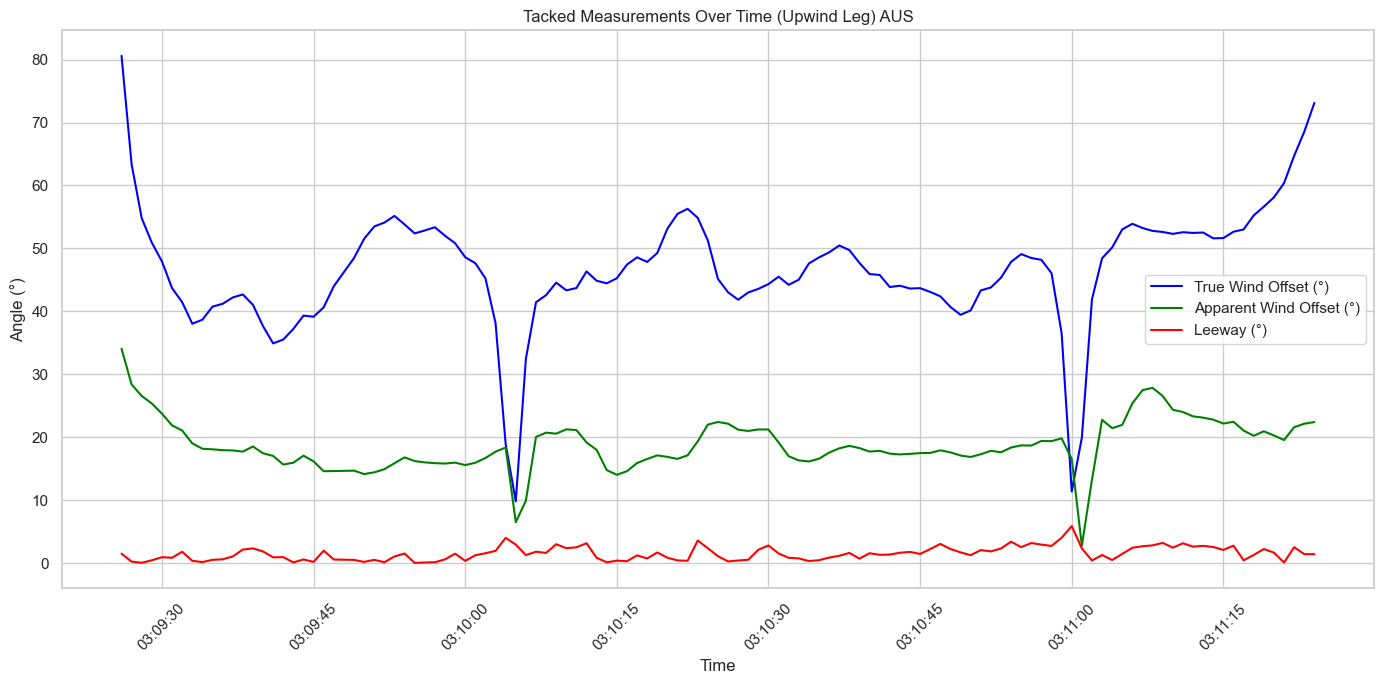

In [198]:
#So i have 3 measurements, the True wind offset, aparent wind offset and leeway offset, each showing the vlue irrespective of the tack making it easier for the sailor to work their numbers.
#I want to now visualise these nicely, and I will rename too 
# Convert DATETIME to a datetime object (adjust dayfirst if needed)
filtered_df['DATETIME'] = pd.to_datetime(filtered_df['DATETIME'], dayfirst=True)

# Plot the offsets over time
plt.figure(figsize=(14,7))
plt.plot(filtered_df['DATETIME'], filtered_df['True_Wind_Offset'], label='True Wind Offset (°)', color='blue')
plt.plot(filtered_df['DATETIME'], filtered_df['Apparent_Wind_Offset'], label='Apparent Wind Offset (°)', color='green')
plt.plot(filtered_df['DATETIME'], filtered_df['Leeway_Offset'], label='Leeway (°)', color='red')

plt.xlabel('Time')
plt.ylabel('Angle (°)')
plt.title('Tacked Measurements Over Time (Upwind Leg) AUS')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
**What I Did:**
1. **Filtered the Data**: I took the AUS boat’s data and isolated only Leg 3 of the first race (the upwind leg).
2. **Calculated Key Offsets**:
   - **True Wind Offset (°)**: The absolute difference between the boat’s heading and the true wind direction, so it always reads as a positive angle.
   - **Apparent Wind Offset (°)**: The absolute value of the apparent wind angle, removing any negative sign so you can instantly see how much the wind is angled relative to the boat.
   - **Leeway (°)**: The absolute value of the sideways drift angle, giving a clear magnitude of how much the boat is slipping sideways due to wind.
3. **Plotted Them Over Time**: I then made a time series chart showing these three angles each second during the upwind leg.  

- By using absolute values (or “tacked” values), sailors don’t have to mentally flip angles when the boat changes tack.  
- A single glance at the chart tells you whether you’re sailing at 35° or 45° to the wind, and how much you’re slipping sideways, regardless of which side the wind is on.
- What I find interesting is the variance in the True Wind Offset line and how quickly the boat goes through the tack and back onto a good true wind offset angle.



In [199]:
# Calculate the average True Wind Offset for the upwind leg I wanted to see the average angle AUS were sailing at
avg_true_wind_offset = filtered_df['True_Wind_Offset'].mean()
print("Average True Wind Offset for Upwind Leg AUS: {:.2f}°".format(avg_true_wind_offset))

Average True Wind Offset for Upwind Leg AUS: 46.76°


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
**Additional Analysis**

- I wanted to explore the upwind sailing angle of the AUS boat and compare this to a boat that was further back in the fleet.

In [200]:
#I just for interest wanted to see a comparison of this with the BRA boat 
#I decided I would make it a little simple as I was quite confused, I will display the wind direction and the boats heading compared to that 

# Load the dataset (update the file path as needed)
df = pd.read_csv('Data/data_BRA.csv')

# Filter for Leg 3 of the first race and make a full copy
filtered_df = df[(df['TRK_LEG_NUM_unk'] == 3) & (df['TRK_RACE_NUM_unk'] == 25011905)].copy()

# Function to normalize an angle to the range [-180, 180]
def normalize_angle(angle):
    return (angle + 180) % 360 - 180

# Calculate wind offset: the absolute difference between the boat's heading and the true wind direction
filtered_df['wind_offset'] = filtered_df.apply(
    lambda row: abs(normalize_angle(row['HEADING_deg'] - row['TWD_SGP_deg'])),
    axis=1
)

# Calculate apparent wind offset: the absolute value of the apparent wind angle
filtered_df['apparent_wind_offset'] = filtered_df['AWA_SGP_deg'].abs()

# Calculate leeway offset: the absolute value of the leeway angle
filtered_df['leeway_offset'] = filtered_df['LEEWAY_deg'].abs()

# Display a few rows to see the results
print(filtered_df[['HEADING_deg', 'TWD_SGP_deg', 'wind_offset', 
                   'AWA_SGP_deg', 'apparent_wind_offset', 
                   'LEEWAY_deg', 'leeway_offset',]].head(50))


     HEADING_deg  TWD_SGP_deg  wind_offset  AWA_SGP_deg  apparent_wind_offset  \
236       134.59        57.12        77.47       -72.57                 72.57   
237       123.72        56.64        67.08       -54.76                 54.76   
238       115.67        56.20        59.47       -48.10                 48.10   
239       110.03        55.46        54.57       -44.05                 44.05   
240       108.14        54.57        53.57       -40.25                 40.25   
241       105.53        53.75        51.78       -37.72                 37.72   
242       103.80        52.93        50.87       -36.67                 36.67   
243       101.72        52.11        49.61       -34.67                 34.67   
244       103.00        51.50        51.50       -33.10                 33.10   
245       105.21        51.13        54.08       -32.38                 32.38   
246       106.59        50.88        55.71       -32.54                 32.54   
247       106.99        50.6

/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/3201498621.py:9: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  filtered_df['DATETIME'] = pd.to_datetime(filtered_df['DATETIME'], dayfirst=True)


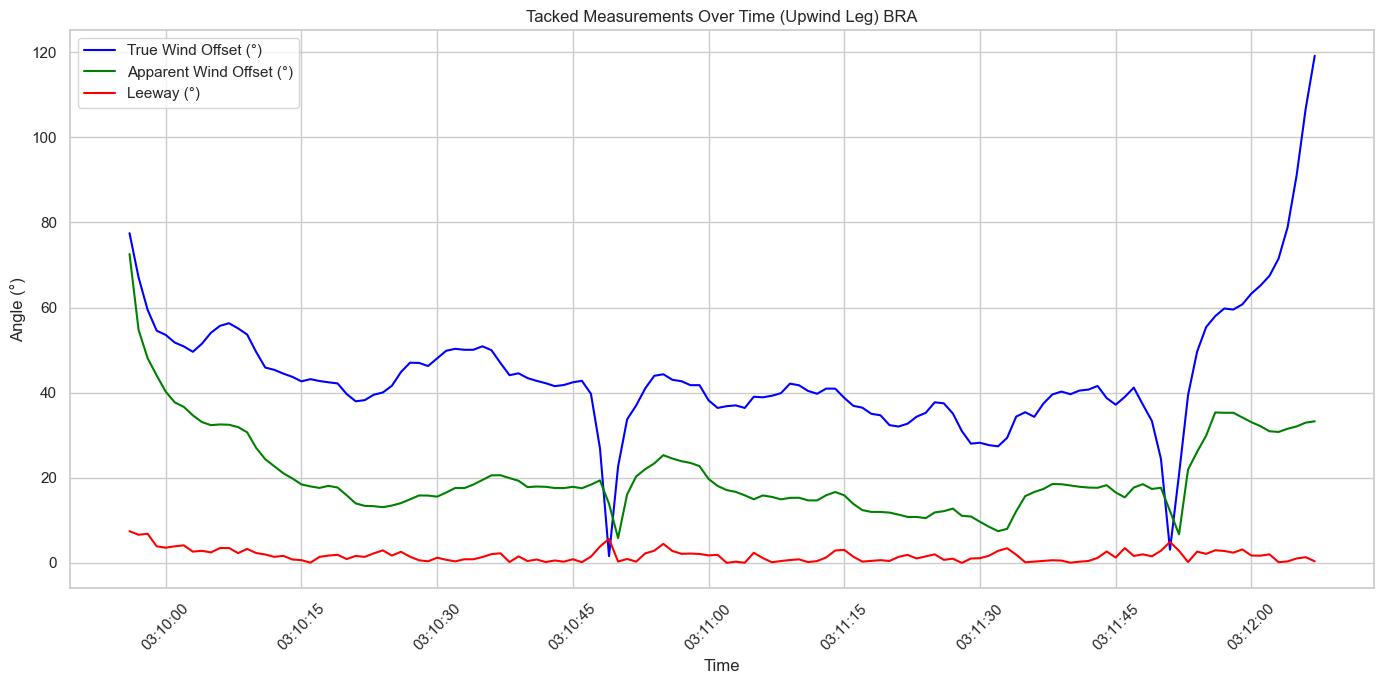

In [201]:
# Rename columns to more descriptive names
filtered_df = filtered_df.rename(columns={
    'wind_offset': 'True Wind Offset',
    'apparent_wind_offset': 'Apparent Wind Offset',
    'leeway_offset': 'Leeway'})


# Convert DATETIME to a datetime object (adjust dayfirst if needed)
filtered_df['DATETIME'] = pd.to_datetime(filtered_df['DATETIME'], dayfirst=True)

plt.figure(figsize=(14,7))
plt.plot(filtered_df['DATETIME'], filtered_df['True Wind Offset'], label='True Wind Offset (°)', color='blue')
plt.plot(filtered_df['DATETIME'], filtered_df['Apparent Wind Offset'], label='Apparent Wind Offset (°)', color='green')
plt.plot(filtered_df['DATETIME'], filtered_df['Leeway'], label='Leeway (°)', color='red')

plt.xlabel('Time')
plt.ylabel('Angle (°)')
plt.title('Tacked Measurements Over Time (Upwind Leg) BRA')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [202]:
# Calculate the average True Wind Offset for the upwind leg
avg_true_wind_offset = filtered_df['True Wind Offset'].mean()
print("Average True Wind Offset for Upwind Leg BRA: {:.2f}°".format(avg_true_wind_offset))

Average True Wind Offset for Upwind Leg BRA: 44.10°


### **Extra analysis on Question 6**

- What is interesting was that the Brazil boat looked to sail at a much higher angle than the AUS boat in the graphs, So i ran the averages and that was confirmed which is interesting. 
- I will explore this further in Q8

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Question 7: Modeling Key Features of Tacks for VMG Optimization

### First I picked my target variable
- I used loss_vs_targ_vmg as a measure of how good or bad the tack was.

Then,

#### **Load and Clean the Data**
- Load the dataset containing race maneuvers.
- Filter the dataset to **only include tacks**, removing other maneuvers.
- Explore the dataset and drop columns that don't add useful info on tacks, including **metadata, theoretical values**.

#### Split Data for Port and Starboard Tacks
- Identify whether a tack was a **port tack** or **starboard tack** using the `'entry_tack'` column.
- Create two separate datasets: **one for port tacks** and **one for starboard tacks**.
- I am doing this to be able to include more variables like **ride heights**.
- Drop additional **low-correlation columns** to the target variable.

#### Feature Selection and Preprocessing
- Remove columns with **near-zero variance** (if applicable).

#### Train a Machine Learning Model (Random Forest)
- Split both the **port and starboard tack datasets** into training and test sets.
- Train a **Random Forest Regressor** on each dataset to predict **`loss_vs_targ_vmg`**.
- Evaluate model performance using:
  - **R² Score** (How well the model explains variance)
  - **Root Mean Squared Error (RMSE)** (Prediction accuracy)

#### SHAP Analysis: Understanding Feature Importance
- Compute **SHAP values** to analyse which features most impact tack performance.
- Visualise:
  - **SHAP Summary Plots** (to show the **global importance** of features).
  - **SHAP Force Plots** (to explain **individual tacks**, showing what helped/hurt VMG).

####  Compare Good vs. Bad Tacks
- Identify **top 3 good tacks** (smallest VMG loss) and **top 3 bad tacks** (largest VMG loss).
- Compute **average values of key features** for good vs. bad tacks.
- Compare and visualise **differences in key variables** that distinguish good vs. bad tacks.

#### **Concerns**
- Without a feature description list for the manouvres I have to assume what each feature is and drop if I am not sure it has impact in the tack.


In [203]:
#Question 7

sns.set(style="whitegrid")

# 1. Load Data, Filter for Tacks, and Clean Up
df = pd.read_csv("Data/2025-01-19_man_summary.csv")
print("Initial columns in the dataset:")
print(df.columns.tolist())

# Filter for tacks only
df = df[df['type'].str.lower() == 'tack']
print("\nUnique values in 'type' after filtering:")
print(df['type'].unique())

# Drop unnecessary columns based on my own assumptions
cols_to_drop = [
    'BOAT', 'HULL', 'WING_CONFIG_unk', 'DATETIME', 'TIME_LOCAL_unk',
    'race', 'leg', 'type',                         # already used for filtering
    'two_DB_time', 'two_DB_Broadcast',             # many missing values
                                                   #some meta data
                                                   #also dropped columns I wasnt sure of meaning
    't_invert',                                    # looks like capsize measurement and there are no capsizes
    'vmg_distance',                             
    'theoretical_vmg', 'theoretical_target_vmg', 'theoretical_distance', 'theoretical_targ_distance', #Dropped all theory based variables
    'htw_bsp',                                     # missing values
    'cant_stow_target', 'dashboard', 
    'MD4_SEL_DB_unk', 'MD4_SEL_RUD_unk',           # day-of selection info
    'bearing', 'bearing_2',                        # unclear meaning
    'b_diff', 'b_diff_1',                          # keep only b_diff_2
    'dist_2',                                      # redundant with 'distance'
    'drop_offset',                                 # metadata
    'cant_drop_target',                            # theoretical
    'max_fwd_gforce', 'max_lat_gforce', 'max_gforce', # removed based on assumptions
    'loss_vs_vmg', 'distance', 'orig_exit_twa' , 'orig_entry_twa' #orig exit and entry seem the same as entry twa and exit twa, loss_vs_vmg similar to target variable
    
]

cols_to_drop_existing = [col for col in cols_to_drop if col in df.columns]
df_clean = df.drop(columns=cols_to_drop_existing)
print("\nDataFrame after initial column drops:")
display(df_clean.head())

# Split into Port and Starboard Datasets

print("\nUnique values in 'entry_tack':")
print(df_clean['entry_tack'].unique())

# Filter based on keywords in 'entry_tack'
df_port = df_clean[df_clean['entry_tack'].str.lower().str.contains('port', na=False)].copy()
df_starboard = df_clean[df_clean['entry_tack'].str.lower().str.contains('stbd', na=False)].copy()

# Drop additional tack-specific columns if present
#Keeps the _S  with the starboard dataset and the _P are with port meaning these features can be used in the models
additional_drop_cols = [
    'drop_time_P', 'drop_time_S', 'unstow_time_P', 'unstow_time_S',
    'stow_time_P', 'stow_time_S', 'boards_up_time_S', 'boards_up_time_P',
    'db_cant_ret_press_p_avg', 'db_cant_ret_press_p_max',
    'db_cant_ret_press_s_avg', 'db_cant_ret_press_s_max',
    'db_cant_ext_press_p_avg', 'db_cant_ext_press_p_max',
    'db_cant_ext_press_s_avg', 'db_cant_ext_press_s_max',
    'entry_tack'
]
for df_side in [df_port, df_starboard]:
    cols_present = [col for col in additional_drop_cols if col in df_side.columns]
    df_side.drop(columns=cols_present, inplace=True)

print("\nPort Tack DataFrame columns before dropping additional low-correlation columns:")
display(df_port.head())
print("\nStarboard Tack DataFrame columns before dropping additional low-correlation columns:")
display(df_starboard.head())

#Perform a correlation analysis and an analysis for near zero variance in a feature and drop any columns with a correlation of >0.05 to target
#and a near zero variance 

# Compute correlation for port and starboard datasets
correlation_port = df_port.corr()['loss_vs_targ_vmg'].sort_values(ascending=False)
correlation_star = df_starboard.corr()['loss_vs_targ_vmg'].sort_values(ascending=False)

# Find features with absolute correlation < 0.05 (very weak correlation)
low_corr_features_port = correlation_port[abs(correlation_port) < 0.05].index.tolist()
low_corr_features_star = correlation_star[abs(correlation_star) < 0.05].index.tolist()

# Print the low-correlation features for both datasets
print("\nPort Tack - Features with correlation < 0.05:")
print(low_corr_features_port)

print("\nStarboard Tack - Features with correlation < 0.05:")
print(low_corr_features_star)


# Drop columns with near-zero variance (if any)
from numpy import isclose
for col in df_port.columns:
    if isclose(df_port[col].std(), 0.0):
        print(f"Dropping {col} from port due to near-zero variance.")
        df_port.drop(columns=[col], inplace=True)
        df_starboard.drop(columns=[col], inplace=True, errors='ignore')
if not any(isclose(df_port[col].std(), 0.0) for col in df_port.columns):
    print("No additional columns dropped due to near-zero variance.")


Initial columns in the dataset:
['BOAT', 'HULL', 'WING_CONFIG_unk', 'MD4_SEL_DB_unk', 'MD4_SEL_RUD_unk', 'DATETIME', 'TIME_LOCAL_unk', 'race', 'leg', 'type', 'entry_bsp', 'exit_bsp', 'min_bsp', 'bsp_loss', 'entry_twa', 'exit_twa', 'orig_entry_twa', 'orig_exit_twa', 'entry_rh', 'exit_rh', 'entry_rh_stability', 'max_yaw_rate', 'db_down', 'two_DB_time', 'two_DB_Broadcast', 'flying', 'tws', 'pop_time', 'turn_min_rh', 't_invert', 't_to_lock', 'max_lat_gforce', 'max_fwd_gforce', 'max_gforce', 'drop_time_P', 'drop_time_S', 'unstow_time_P', 'unstow_time_S', 'stow_time_P', 'stow_time_S', 'boards_up_time_S', 'boards_up_time_P', 'press_sys_acc_start', 'press_sys_acc_end', 'press_sys_acc_delta', 'press_rake_acc_start', 'press_rake_acc_end', 'press_rake_acc_delta', 'pump_press_avg', 'pump_press_max', 'press_wing_acc_start', 'press_wing_acc_end', 'db_ud_ret_press_s_avg', 'db_ud_ret_press_s_max', 'db_ud_ret_press_p_avg', 'db_ud_ret_press_p_max', 'db_ud_ext_press_s_avg', 'db_ud_ext_press_s_max', 'db_u

,entry_bsp,exit_bsp,min_bsp,bsp_loss,entry_twa,exit_twa,entry_rh,exit_rh,entry_rh_stability,max_yaw_rate,...,entry_jib_sheet_pct,exit_jib_sheet_pct,max_rudder_angle,b_diff_2,avg_TWD,loss_vs_targ_vmg,drop_to_wind_axis,entry_cant,exit_cant,entry_tack
1,58.42,46.90,37.35,21.07,37.5,59.2,1087.1,828.5,1530.7,30.50,...,11.426667,24.459000,14.0,-178.538608,61.118205,20.583132,3.8,-4.888889,-0.1934,port
3,59.34,53.40,41.32,18.02,74.2,60.6,886.7,1000.1,2000.0,33.58,...,46.249000,18.306000,13.5,-172.352779,59.811500,-277.490624,4.2,-2.161800,-2.1534,port
4,58.09,54.27,39.72,18.37,40.0,43.5,996.2,1082.8,1356.6,35.65,...,8.001000,13.977391,14.8,-178.314335,64.548673,6.699322,3.4,-4.848400,-2.1250,stbd
5,50.93,25.02,21.40,29.53,53.0,36.7,889.0,93.6,2000.0,12.88,...,29.568000,58.859000,10.5,-158.472957,63.710000,73.397058,7.4,2.386200,2.1690,port
7,59.83,47.25,20.35,39.48,50.3,60.9,882.4,836.4,1935.5,20.39,...,14.878000,24.194000,14.4,166.581429,64.726250,52.218456,3.6,-4.790400,3.3090,stbd



Unique values in 'entry_tack':
['port' 'stbd']

Port Tack DataFrame columns before dropping additional low-correlation columns:


,entry_bsp,exit_bsp,min_bsp,bsp_loss,entry_twa,exit_twa,entry_rh,exit_rh,entry_rh_stability,max_yaw_rate,...,exit_jib_sheet,entry_jib_sheet_pct,exit_jib_sheet_pct,max_rudder_angle,b_diff_2,avg_TWD,loss_vs_targ_vmg,drop_to_wind_axis,entry_cant,exit_cant
1,58.42,46.90,37.35,21.07,37.5,59.2,1087.1,828.5,1530.7,30.50,...,5.949,11.426667,24.459,14.0,-178.538608,61.118205,20.583132,3.8,-4.888889,-0.1934
3,59.34,53.40,41.32,18.02,74.2,60.6,886.7,1000.1,2000.0,33.58,...,7.312,46.249000,18.306,13.5,-172.352779,59.811500,-277.490624,4.2,-2.161800,-2.1534
5,50.93,25.02,21.40,29.53,53.0,36.7,889.0,93.6,2000.0,12.88,...,10.199,29.568000,58.859,10.5,-158.472957,63.710000,73.397058,7.4,2.386200,2.1690
12,56.75,54.34,39.73,17.02,43.2,42.9,946.1,926.0,2000.0,32.06,...,6.224,7.598000,12.732,12.5,-178.455432,71.849750,-27.704267,3.4,-3.340400,-1.8352
16,59.16,54.91,42.26,16.90,43.0,55.8,901.8,1150.2,1980.5,35.60,...,6.591,7.581111,15.197,13.8,-177.085284,67.766154,-7.151008,4.1,-5.026889,-1.2418



Starboard Tack DataFrame columns before dropping additional low-correlation columns:


,entry_bsp,exit_bsp,min_bsp,bsp_loss,entry_twa,exit_twa,entry_rh,exit_rh,entry_rh_stability,max_yaw_rate,...,exit_jib_sheet,entry_jib_sheet_pct,exit_jib_sheet_pct,max_rudder_angle,b_diff_2,avg_TWD,loss_vs_targ_vmg,drop_to_wind_axis,entry_cant,exit_cant
4,58.09,54.27,39.72,18.37,40.0,43.5,996.2,1082.8,1356.6,35.65,...,6.883043,8.001,13.977391,14.8,-178.314335,64.548673,6.699322,3.4,-4.8484,-2.1250
7,59.83,47.25,20.35,39.48,50.3,60.9,882.4,836.4,1935.5,20.39,...,8.724000,14.878,24.194000,14.4,166.581429,64.726250,52.218456,3.6,-4.7904,3.3090
11,59.64,49.40,38.96,20.68,46.1,43.5,1131.3,1055.7,2000.0,28.15,...,7.025000,10.516,13.915000,13.0,175.937495,68.147500,-18.339729,4.2,-2.9502,-2.4914
15,58.07,51.59,36.91,21.16,44.4,51.2,1022.2,1063.2,2000.0,28.82,...,5.946000,9.939,18.047000,12.9,173.088697,65.569000,-8.968872,5.4,-4.5784,-0.9976
18,55.22,57.08,41.95,13.27,38.6,46.0,971.1,940.1,2000.0,30.41,...,6.912000,11.647,12.371000,12.6,-178.799478,61.977750,-50.898091,4.0,-5.1756,-3.2528



Port Tack - Features with correlation < 0.05:
['db_ud_ret_press_s_avg', 'entry_jib_sheet_pct', 'entry_pitch', 'avg_TWD', 'db_down', 'press_sys_acc_end', 'db_ud_ext_press_s_avg', 'press_sys_acc_delta', 'db_ud_ret_press_p_avg', 'press_sys_acc_start', 'b_diff_2', 'db_ud_ext_press_s_max']

Starboard Tack - Features with correlation < 0.05:
['tws', 'press_sys_acc_delta', 'press_rake_acc_start', 'press_sys_acc_start', 'b_diff_2', 'press_sys_acc_end']
No additional columns dropped due to near-zero variance.



Port Tack DataFrame columns after dropping additional columns:
['entry_bsp', 'exit_bsp', 'min_bsp', 'bsp_loss', 'entry_twa', 'exit_twa', 'entry_rh', 'exit_rh', 'entry_rh_stability', 'max_yaw_rate', 'db_down', 'flying', 'tws', 'pop_time', 'turn_min_rh', 't_to_lock', 'press_rake_acc_start', 'press_rake_acc_end', 'press_rake_acc_delta', 'pump_press_avg', 'pump_press_max', 'press_wing_acc_start', 'press_wing_acc_end', 'db_ud_ret_press_s_avg', 'db_ud_ret_press_s_max', 'db_ud_ret_press_p_avg', 'db_ud_ret_press_p_max', 'db_ud_ext_press_s_avg', 'db_ud_ext_press_s_max', 'db_ud_ext_press_p_avg', 'db_ud_ext_press_p_max', 'entry_heel', 'entry_pitch', 'exit_heel', 'exit_pitch', 'turning_time', 't_swap', 'bsp_at_drop', 'heel_at_drop', 'pitch_at_drop', 'winward_rh_at_drop', 'entry_jib_lead', 'exit_jib_lead', 'entry_jib_sheet', 'exit_jib_sheet', 'entry_jib_sheet_pct', 'exit_jib_sheet_pct', 'max_rudder_angle', 'avg_TWD', 'loss_vs_targ_vmg', 'drop_to_wind_axis', 'entry_cant', 'exit_cant']

Starboard Ta

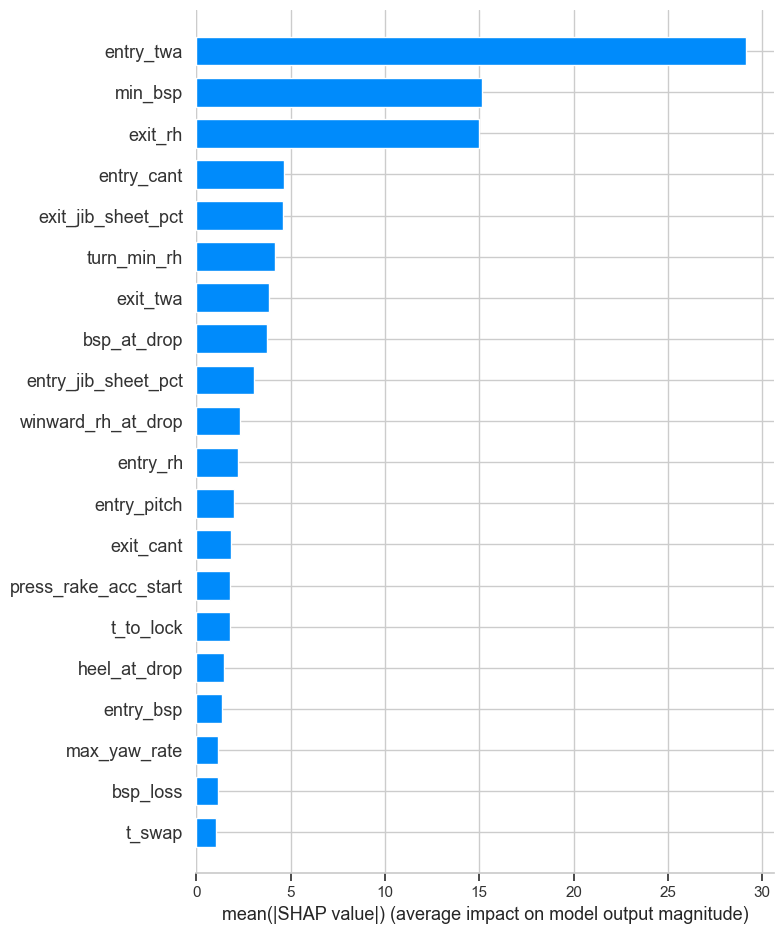


Starboard Tack SHAP Summary:


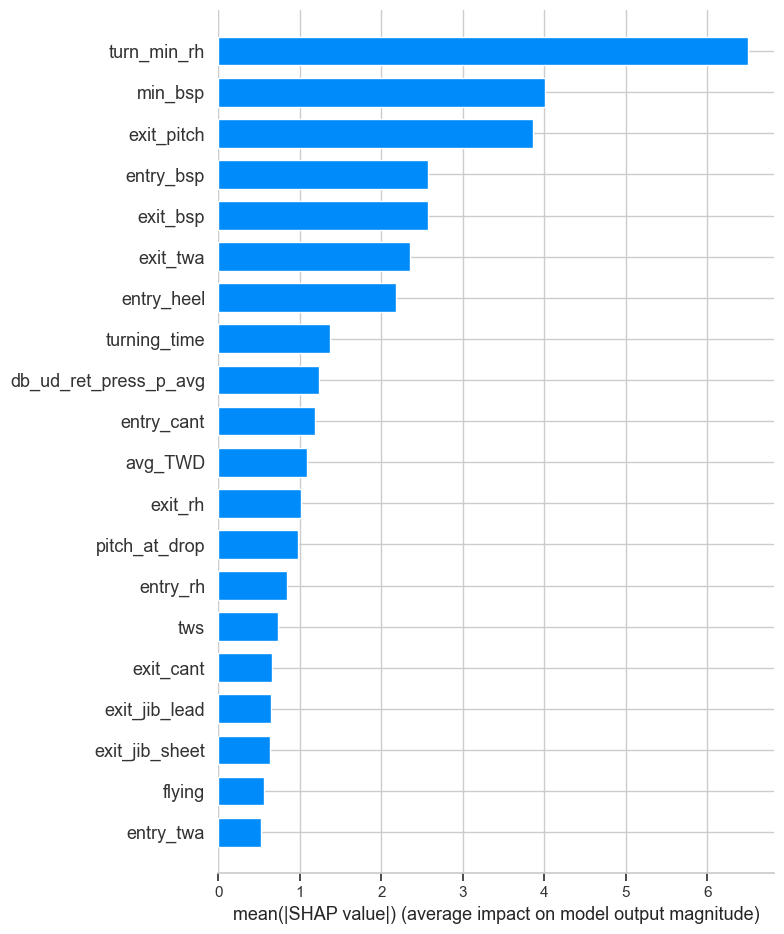

Port Tack SHAP Beeswarm Summary Plot:


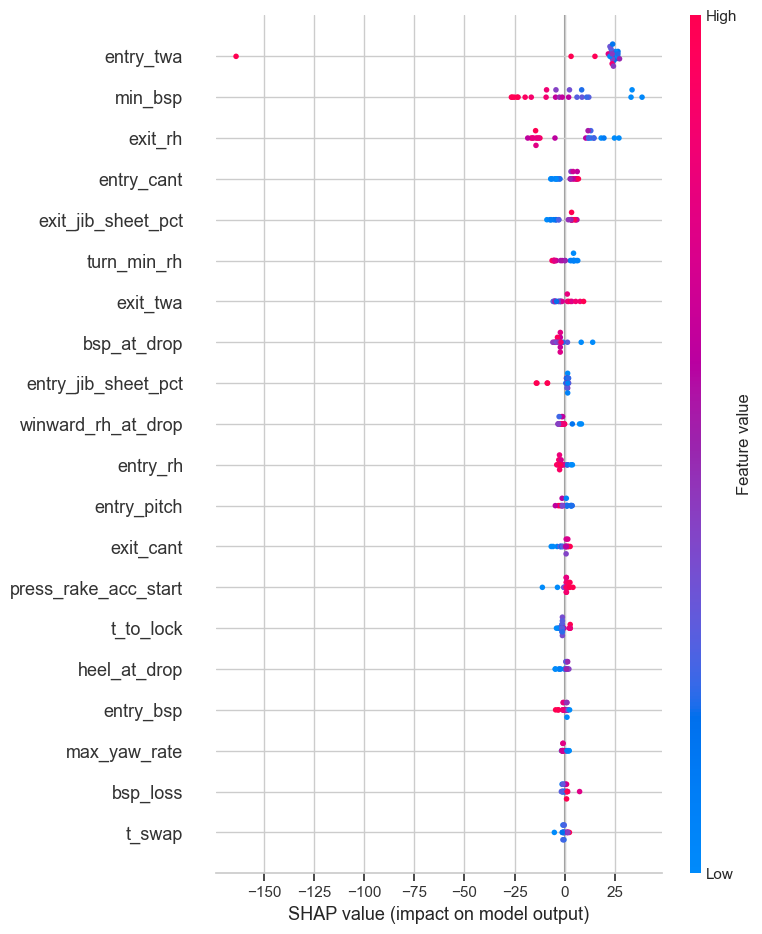

Starboard Tack SHAP Beeswarm Summary Plot:


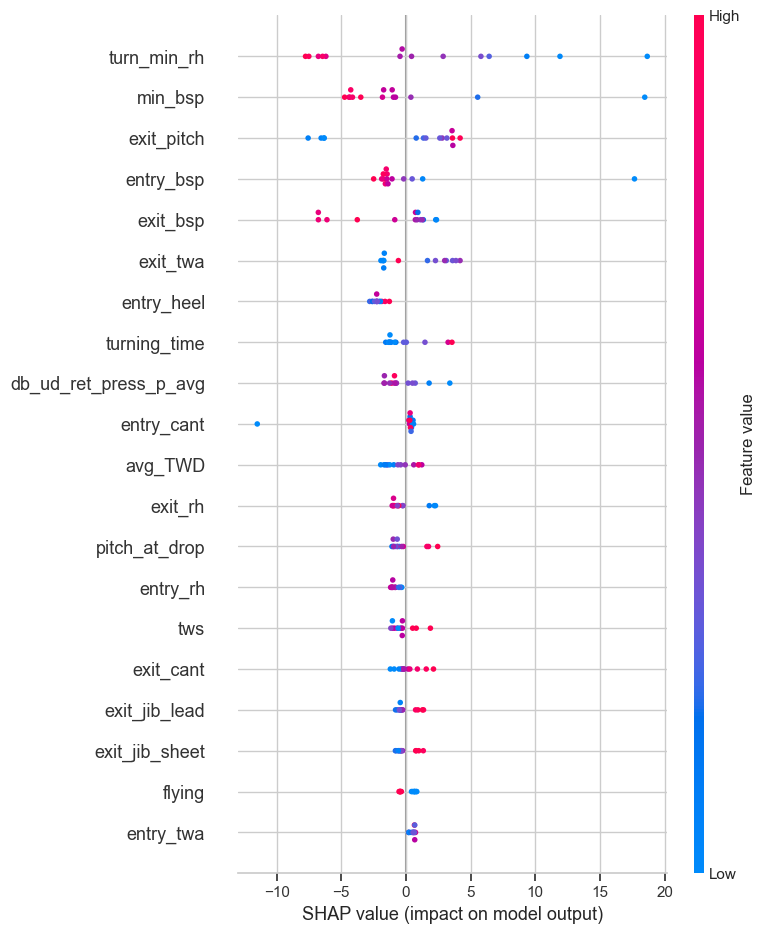

Port Tack - 3 Good Tacks (Lowest loss_vs_targ_vmg):

Port Tack Good Sample (index: 47):


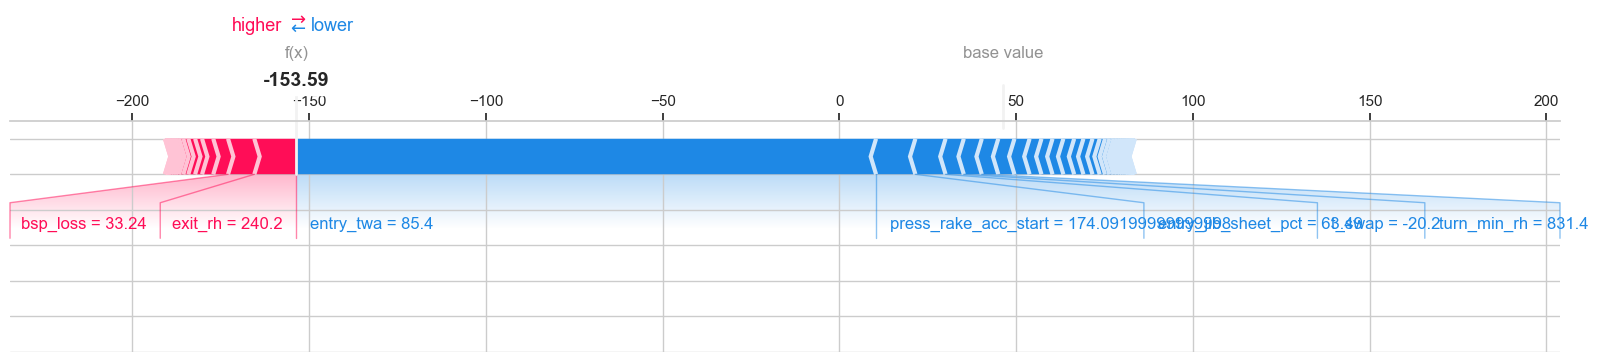


Port Tack Good Sample (index: 143):


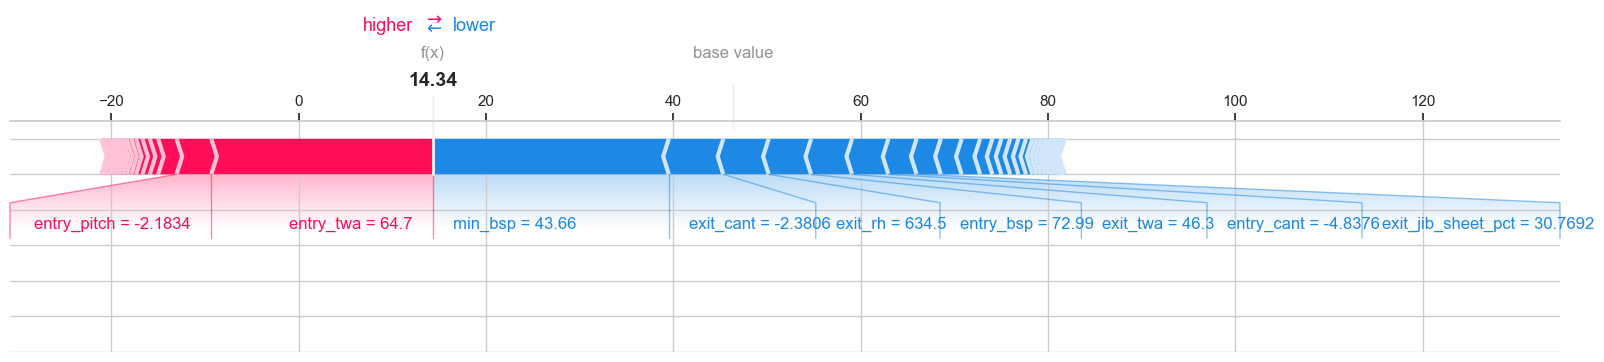


Port Tack Good Sample (index: 217):


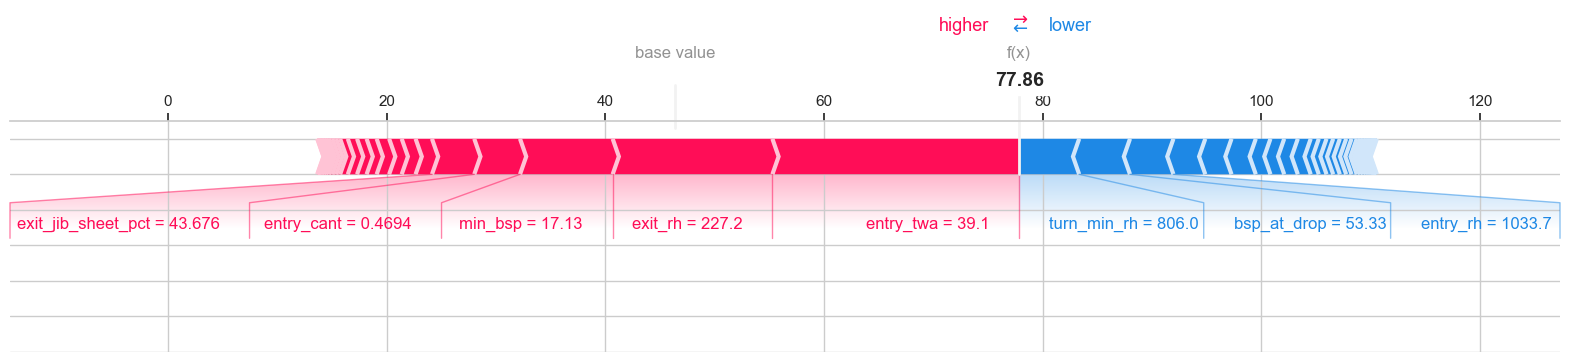


Port Tack - 3 Bad Tacks (Highest loss_vs_targ_vmg):

Port Tack Bad Sample (index: 223):


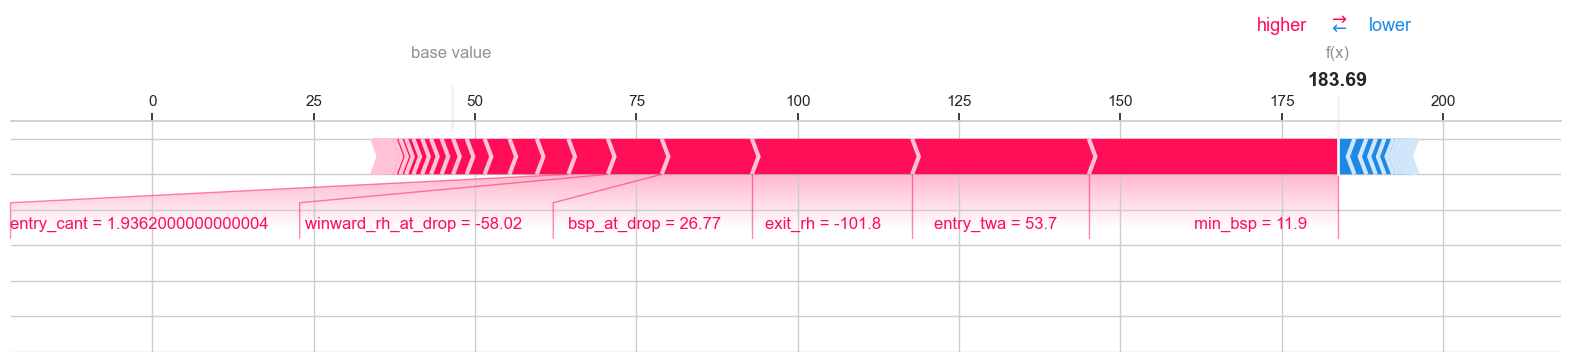


Port Tack Bad Sample (index: 249):


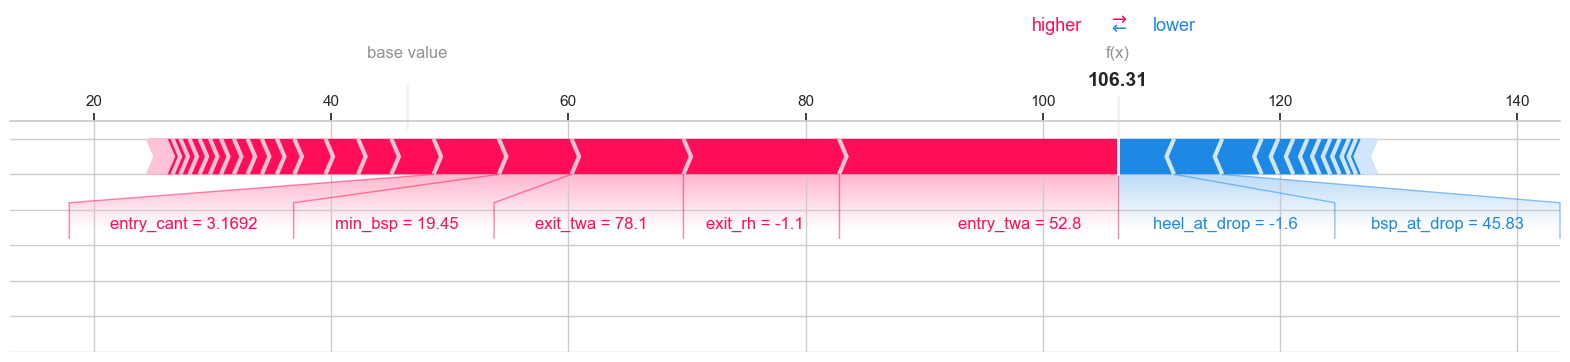


Port Tack Bad Sample (index: 251):


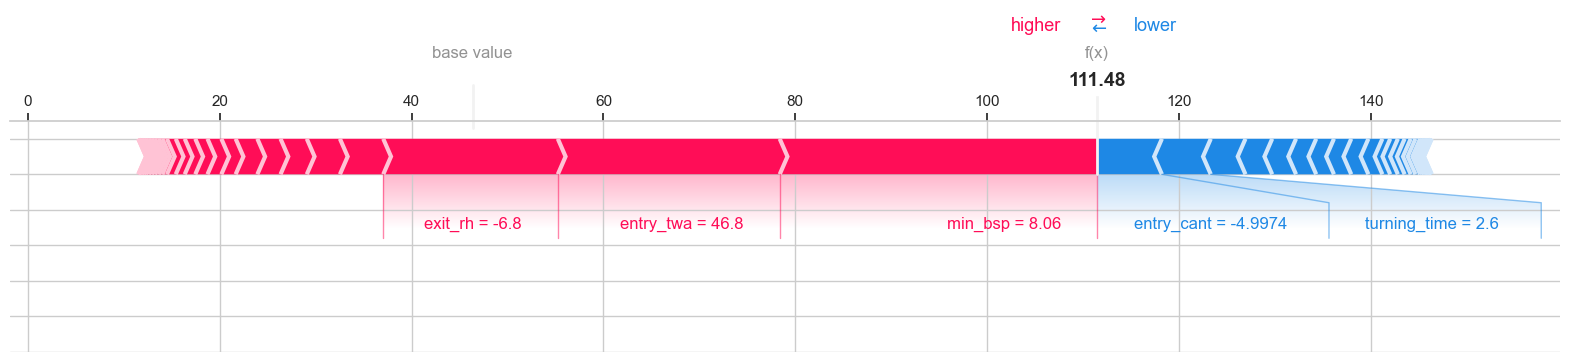


Starboard Tack - 3 Good Tacks (Lowest loss_vs_targ_vmg):

Starboard Tack Good Sample (index: 18):


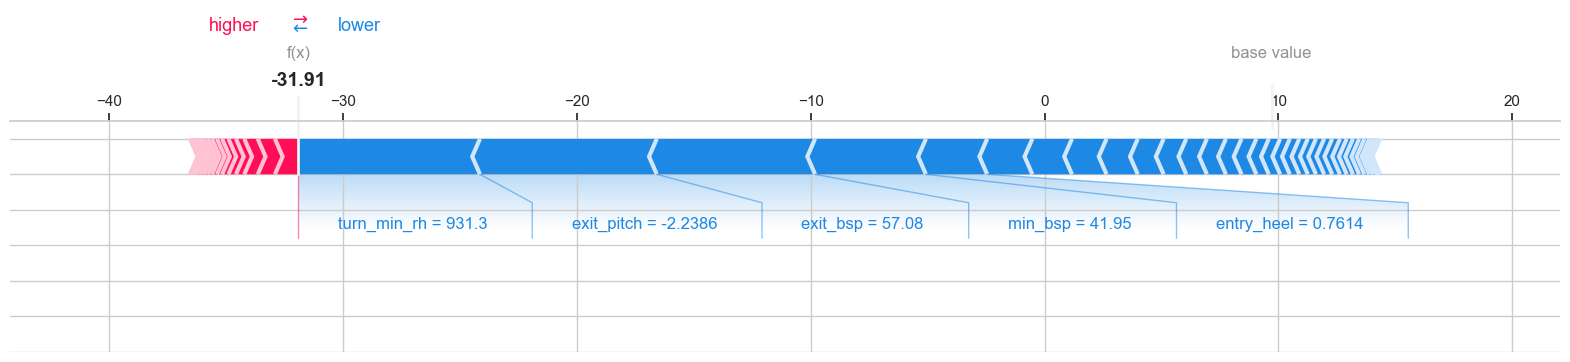


Starboard Tack Good Sample (index: 229):


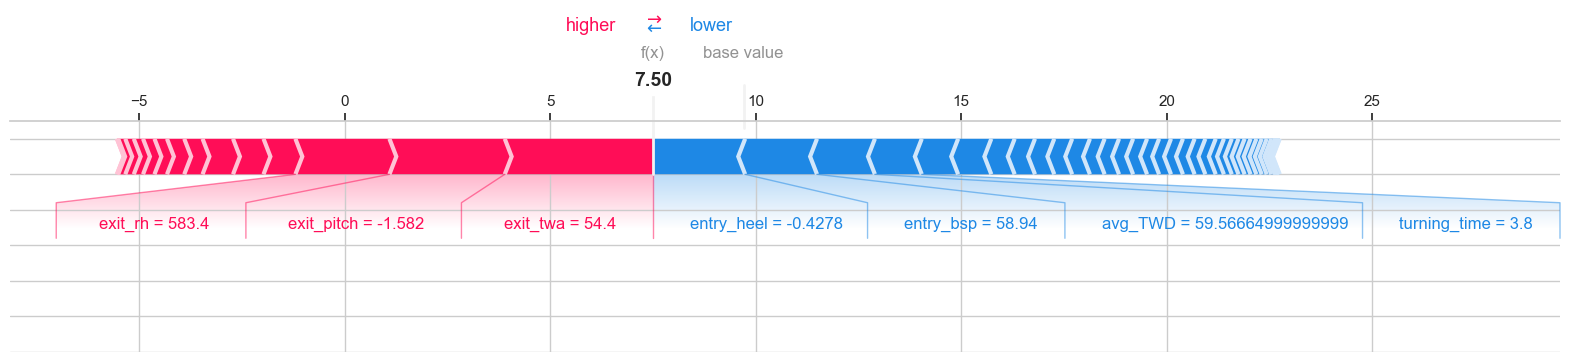


Starboard Tack Good Sample (index: 134):


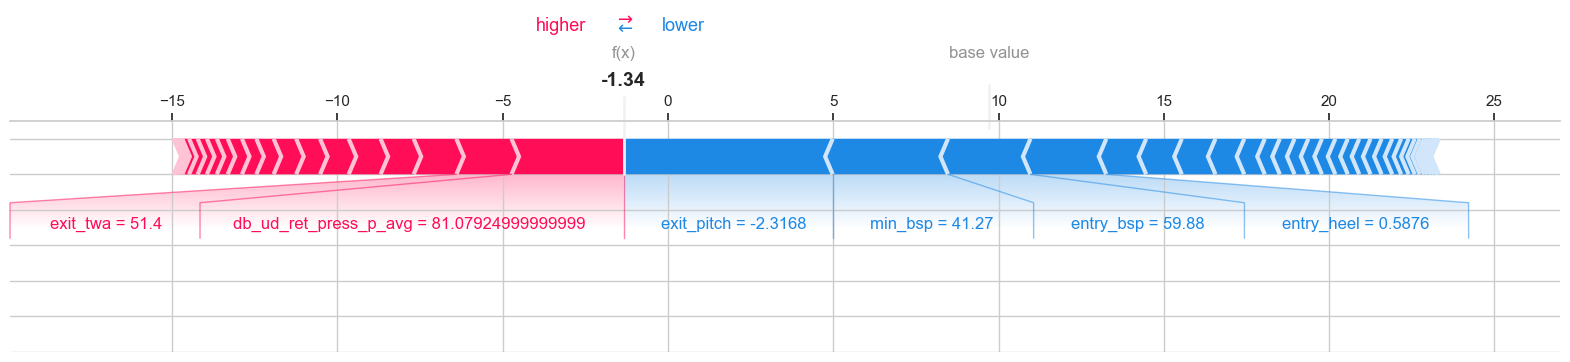


Starboard Tack - 3 Bad Tacks (Highest loss_vs_targ_vmg):

Starboard Tack Bad Sample (index: 67):


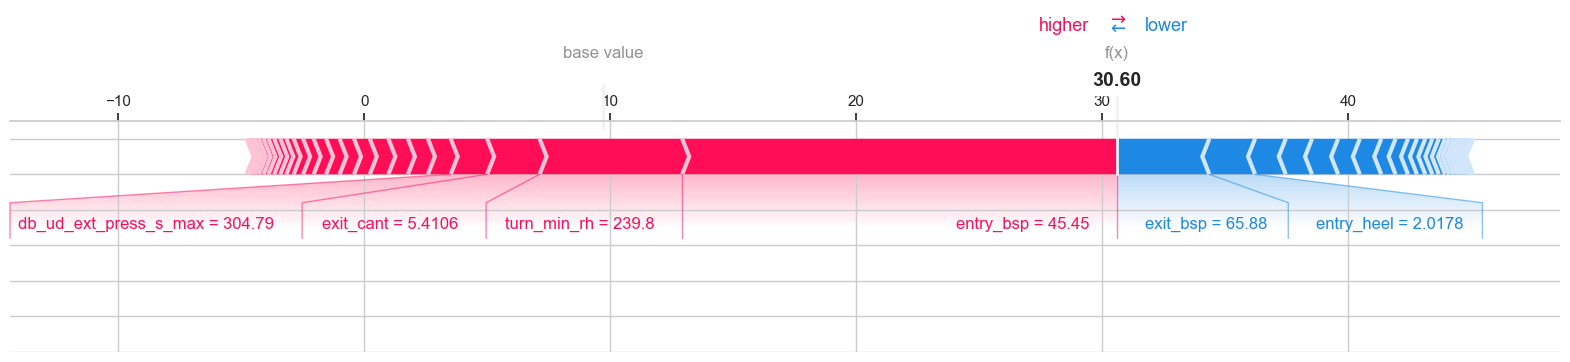


Starboard Tack Bad Sample (index: 299):


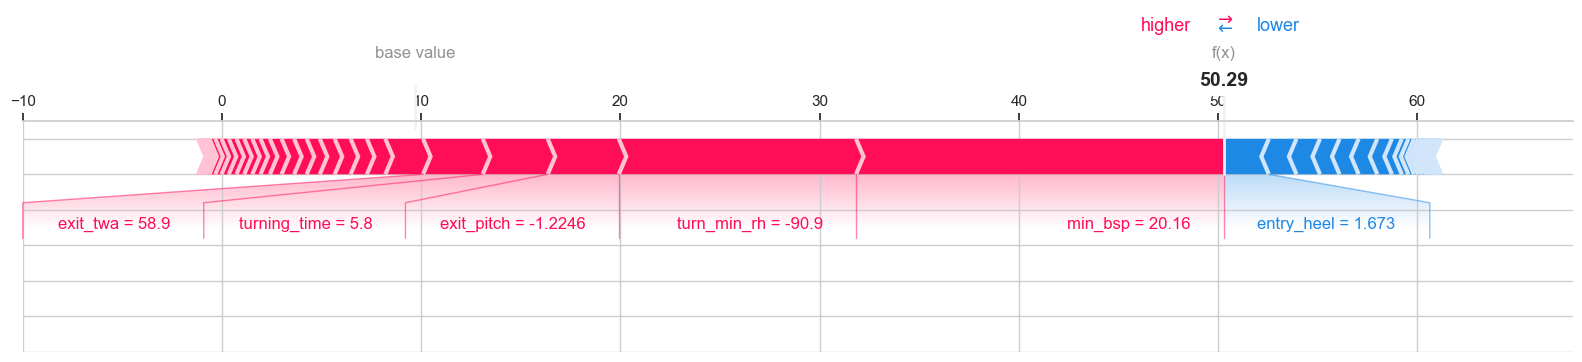


Starboard Tack Bad Sample (index: 171):


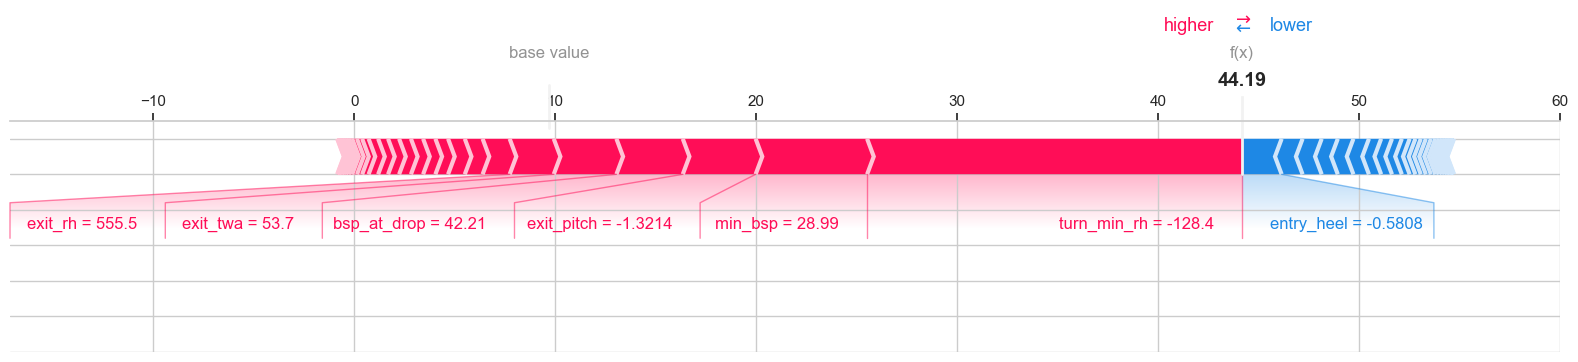

Port Tack Feature Comparison (Average Values):


,Good Tacks,Bad Tacks,Difference
turn_min_rh,625.100000,-205.100000,830.200000
winward_rh_at_drop,1149.153333,373.320000,775.833333
exit_rh,367.300000,-36.566667,403.866667
entry_rh,992.133333,629.833333,362.300000
db_ud_ext_press_p_max,121.530000,280.043333,-158.513333
db_ud_ext_press_p_avg,20.019700,124.903550,-104.883850
db_ud_ret_press_s_max,344.326667,304.460000,39.866667
exit_jib_sheet_pct,35.657933,74.728067,-39.070133
db_ud_ext_press_s_max,117.656667,155.693333,-38.036667
bsp_at_drop,60.006667,38.340000,21.666667


Starboard Tack Feature Comparison (Average Values):


,Good Tacks,Bad Tacks,Difference
turn_min_rh,582.100000,6.833333,575.266667
entry_rh_stability,1815.766667,1447.400000,368.366667
winward_rh_at_drop,1119.410000,897.420000,221.990000
entry_rh,970.800000,1042.033333,-71.233333
db_ud_ext_press_s_max,79.660000,143.886667,-64.226667
exit_rh,766.366667,818.166667,-51.800000
exit_jib_lead,56.468533,89.834333,-33.365800
db_ud_ext_press_s_avg,36.350350,61.780317,-25.429967
db_ud_ret_press_s_max,321.200000,297.356667,23.843333
db_ud_ext_press_p_max,100.740000,122.366667,-21.626667


In [204]:
#no columns had near zero variance and 4 columns had low correlations in both datasets so were dropped from both
cols_to_drop_additional = [ 'press_sys_acc_delta', 'b_diff_2', 'press_sys_acc_end', 'press_sys_acc_start'] #dropped columns that had a low correlation in both datasets
for df_side in [df_port, df_starboard]:
    cols_existing = [col for col in cols_to_drop_additional if col in df_side.columns]
    df_side.drop(columns=cols_existing, inplace=True)

print("\nPort Tack DataFrame columns after dropping additional columns:")
print(df_port.columns.tolist())
print("\nStarboard Tack DataFrame columns after dropping additional columns:")
print(df_starboard.columns.tolist())

# Prepare Data for Modeling (Using loss_vs_targ_vmg as target)

# For Port Tacks:
X_port = df_port.drop(columns=['loss_vs_targ_vmg'])
y_port = df_port['loss_vs_targ_vmg']
X_port = X_port.select_dtypes(include=[np.number])
df_port_model = pd.concat([X_port, y_port], axis=1).dropna()
X_port = df_port_model.drop(columns=['loss_vs_targ_vmg'])
y_port = df_port_model['loss_vs_targ_vmg']
print("\nPort Tack model dataset shape:", X_port.shape)

# For Starboard Tacks:
X_star = df_starboard.drop(columns=['loss_vs_targ_vmg'])
y_star = df_starboard['loss_vs_targ_vmg']
X_star = X_star.select_dtypes(include=[np.number])
df_star_model = pd.concat([X_star, y_star], axis=1).dropna()
X_star = df_star_model.drop(columns=['loss_vs_targ_vmg'])
y_star = df_star_model['loss_vs_targ_vmg']
print("Starboard Tack model dataset shape:", X_star.shape)

#The porttack had considerably more examples but thats okay as both are split into two different models however I suspect the port model will be much more reliable


# Build Models for Port and Starboard Tacks

from sklearn.model_selection import train_test_split

# Split Port Tack dataset
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_port, y_port, test_size=0.2, random_state=42)
# Split Starboard Tack dataset
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_star, y_star, test_size=0.2, random_state=42)

# Build RandomForestRegressor models
rf_port = RandomForestRegressor(n_estimators=100, random_state=42)
rf_port.fit(X_train_p, y_train_p)
y_pred_p = rf_port.predict(X_test_p)

rf_star = RandomForestRegressor(n_estimators=100, random_state=42)
rf_star.fit(X_train_s, y_train_s)
y_pred_s = rf_star.predict(X_test_s)

# Evaluate models
print("\nPort Tack Model Performance:")
print("  R2 Score:", r2_score(y_test_p, y_pred_p))
print("  RMSE:", np.sqrt(mean_squared_error(y_test_p, y_pred_p)))

print("\nStarboard Tack Model Performance:")
print("  R2 Score:", r2_score(y_test_s, y_pred_s))
print("  RMSE:", np.sqrt(mean_squared_error(y_test_s, y_pred_s)))

#Port Tack Model Performance:
# R2 Score: 0.8294950060104231
#  RMSE: 32.55919072565823

#Starboard Tack Model Performance:
#  R2 Score: 0.3396567161744387
#  RMSE: 42.758676665841655

#as expected the starboard model has a much poorer performance due to lack of samples, I will note this for analysis 

# 4. SHAP Analysis 

explainer_p = shap.TreeExplainer(rf_port)
shap_values_p = explainer_p.shap_values(X_test_p)
print("\nPort Tack SHAP Summary:")
shap.summary_plot(shap_values_p, X_test_p, plot_type="bar")

explainer_s = shap.TreeExplainer(rf_star)
shap_values_s = explainer_s.shap_values(X_test_s)
print("\nStarboard Tack SHAP Summary:")
shap.summary_plot(shap_values_s, X_test_s, plot_type="bar")


#  SHAP Visualisations: Beeswarm and Force Plots to show a summary of the important features in tacks 

# SHAP Beeswarm Summary Plots to show importance of top features across all tacks in each model 
# For Port Tack Model
print("Port Tack SHAP Beeswarm Summary Plot:")
shap.summary_plot(shap_values_p, X_test_p, plot_type="dot", feature_names=X_test_p.columns)

# For Starboard Tack Model
print("Starboard Tack SHAP Beeswarm Summary Plot:")
shap.summary_plot(shap_values_s, X_test_s, plot_type="dot", feature_names=X_test_s.columns)

# SHAP Force Plots for Individual Predictions (Top 3 Good and Top 3 Bad) of each model 

import shap
shap.initjs()

# ----- For Port Tacks -----
print("Port Tack - 3 Good Tacks (Lowest loss_vs_targ_vmg):")
good_idxs_port = y_test_p.nsmallest(3).index  # lowest loss -> good tacks
for idx in good_idxs_port:
    pos = X_test_p.index.get_loc(idx)
    print(f"\nPort Tack Good Sample (index: {idx}):")
    shap.force_plot(explainer_p.expected_value, shap_values_p[pos], X_test_p.iloc[pos], matplotlib=True)

print("\nPort Tack - 3 Bad Tacks (Highest loss_vs_targ_vmg):")
bad_idxs_port = y_test_p.nlargest(3).index  # highest loss -> bad tacks
for idx in bad_idxs_port:
    pos = X_test_p.index.get_loc(idx)
    print(f"\nPort Tack Bad Sample (index: {idx}):")
    shap.force_plot(explainer_p.expected_value, shap_values_p[pos], X_test_p.iloc[pos], matplotlib=True)

# ----- For Starboard Tacks -----
print("\nStarboard Tack - 3 Good Tacks (Lowest loss_vs_targ_vmg):")
good_idxs_star = y_test_s.nsmallest(3).index  # lowest loss -> good tacks
for idx in good_idxs_star:
    pos = X_test_s.index.get_loc(idx)
    print(f"\nStarboard Tack Good Sample (index: {idx}):")
    shap.force_plot(explainer_s.expected_value, shap_values_s[pos], X_test_s.iloc[pos], matplotlib=True)

print("\nStarboard Tack - 3 Bad Tacks (Highest loss_vs_targ_vmg):")
bad_idxs_star = y_test_s.nlargest(3).index  # highest loss -> bad tacks
for idx in bad_idxs_star:
    pos = X_test_s.index.get_loc(idx)
    print(f"\nStarboard Tack Bad Sample (index: {idx}):")
    shap.force_plot(explainer_s.expected_value, shap_values_s[pos], X_test_s.iloc[pos], matplotlib=True)


# Compare Feature Averages for Good vs. Bad Tacks

import matplotlib.pyplot as plt

# ---- For Port Tacks ----
# Select the three best and three worst tacks from the test set
good_idxs_port = y_test_p.nsmallest(3).index
bad_idxs_port = y_test_p.nlargest(3).index

# Extract corresponding feature data
X_good_port = X_test_p.loc[good_idxs_port]
X_bad_port = X_test_p.loc[bad_idxs_port]

# Compute mean values for each feature in good vs. bad tacks
mean_good_port = X_good_port.mean()
mean_bad_port = X_bad_port.mean()

# Create a comparison DataFrame
comparison_port = pd.DataFrame({
    'Good Tacks': mean_good_port,
    'Bad Tacks': mean_bad_port
})
comparison_port['Difference'] = comparison_port['Good Tacks'] - comparison_port['Bad Tacks']
# Sort features by the absolute difference (largest differences on top)
comparison_port_sorted = comparison_port.sort_values(by='Difference', key=abs, ascending=False)

print("Port Tack Feature Comparison (Average Values):")
display(comparison_port_sorted)

# ---- For Starboard Tacks ----
good_idxs_star = y_test_s.nsmallest(3).index
bad_idxs_star = y_test_s.nlargest(3).index

X_good_star = X_test_s.loc[good_idxs_star]
X_bad_star = X_test_s.loc[bad_idxs_star]

mean_good_star = X_good_star.mean()
mean_bad_star = X_bad_star.mean()

comparison_star = pd.DataFrame({
    'Good Tacks': mean_good_star,
    'Bad Tacks': mean_bad_star
})
comparison_star['Difference'] = comparison_star['Good Tacks'] - comparison_star['Bad Tacks']
comparison_star_sorted = comparison_star.sort_values(by='Difference', key=abs, ascending=False)

print("Starboard Tack Feature Comparison (Average Values):")
display(comparison_star_sorted)



-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## **Analaysis of the Models** 

## **Port tack model** 
- Port Tack model dataset shape: (114, 52)
- Port Tack Model Performance:
- R2 Score: 0.825294444123323
- RMSE: 32.95781473060134
- The R2 Score indicates that the model explains about 82.5% of the variance in the target variable, which is strong performance.
- The error metric is relatively low, suggesting the predictions are reasonably close to the actual values.

## **Starboard tack model**
- Starboard Tack model dataset shape: (67, 52)
- Starboard Tack Model Performance: 
- R2 Score: 0.37498449336322326
- RMSE: 41.59917995077272 
- The model only explains about 37.5% of the variance, indicating a much weaker performance compared to the Port Tack model.
- A higher RMSE reflects larger prediction errors.
- I believe this is primarily down to fewer samples 

## **Conclusion**
- I will focus my analysis on the Port model as it is more reliable, the focus of this task was to analyse features of tacks to optimise vmg so that will be my main focus of the analysis


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# **Results** 
- I will only analyse the Port model results due to the significantly underperforming results of the starboard model

### **Port tacks** 
- I will take the top 10 most important features from the Shap Plot for the Port model and then show the differences in Good and Bad tacks using my average values table 

## **Analysis of Key Features Influencing Port Tack Performance**

Using SHAP values, I identified the most important features that influence tack performance in terms of VMG loss. Below, I analyse the top ten features from the model and their differences between good and bad tacks.

### **1. Entry TWA (True Wind Angle)**
- **Good Tacks:** 63.07°
- **Bad Tacks:** 51.10°  
- **Difference:** **+11.97°**
- A higher **entry TWA** in good tacks suggests that boats enter the tack on a broader angle usually have a more effective tack.

### **2. Minimum Boat Speed (min_bsp)**
- **Good Tacks:** 30.17 knots
- **Bad Tacks:** 13.14 knots  
- **Difference:** **+17.03 knots**
- Good tacks maintain a significantly higher **minimum boat speed**, indicating smoother transitions and less deceleration through the manoeuvre.

### **3. Exit Ride Height**
- **Good Tacks:** 367.30
- **Bad Tacks:** -36.57  
- **Difference:** **+403.87**
- Bad tacks tend to have a low exit ride height, this correlates with a lower entry ride height
- **Good Tacks:** Entry ride height is more than 50% higher than bad tacks entry RH

### **4. Entry Cant Angle (entry_cant)**
- **Good Tacks:** -2.77
- **Bad Tacks:** 0.036  
- **Difference:** **-2.81**
- Good tacks tend to have a **negative cant angle**.

### **5. Exit Jib Sheet Percentage (exit_jib_sheet_pct)**
- **Good Tacks:** 35.66%
- **Bad Tacks:** 74.73%  
- **Difference:** **-39.07%**
- In good tacks, the jib sheet percentage is considerably lower.

### **6. Turn Minimum RH (turn_min_rh)**
- **Good Tacks:** 625.10
- **Bad Tacks:** -205.10  
- **Difference:** **+830.20**
- Good tacks involve a well-controlled ride height, keeping well above the water line.

### **7. Exit TWA (exit_twa)**
- **Good Tacks:** 47.17°
- **Bad Tacks:** 46.80°  
- **Difference:** **+0.37°**
- The minor difference suggests **entry TWA** is more critical than exit TWA in predicting good tack performance , but it does slightly suggest at not pinching after the tack.

### **8. Boat Speed at Drop (bsp_at_drop)**
- **Good Tacks:** 60.01 knots
- **Bad Tacks:** 38.34 knots  
- **Difference:** **+21.67 knots**
- A higher **boat speed at drop** of the daggerboards ensures a more efficient tack, sailors want to be at full speed before the board is dropped.

### **9. Entry Jib Sheet Percentage (entry_jib_sheet_pct)**
- **Good Tacks:** 37.34%
- **Bad Tacks:** 30.70%  
- **Difference:** **+6.64%**
- In good tacks, the jib is trimmed slightly less before the tack. 
- A good tack seems to have a less trimmed entry sheet, and the sheet is pulled on slighlty after the tack, in a bad tack at the exit the sheet is dumped significantly.

### **10. Winward RH at Drop (winward_rh_at_drop)**
- **Good Tacks:** 1149.15
- **Bad Tacks:** 373.32  
- **Difference:** **+775.83**
- Again the ride height is crucial for a good tack. 

## **Key Takeaways**
- **Entry angle** Entering the tack from a lower angle to the wind makes a more effective tack
- **Maximising speed into tack** Max speed before the tack is crucial
- **Control of Ride Height** Ride Height plays a crucial role in tack effectiveness, the higher the ride height the better the tack
- **Jib Trim** Dumping the Jib Sheet after the tack and having it too tight before cause a worse tack

## **Individual Good and Bad tacks** 

- In the three good port tacks we see : 

- A consitent presence of **High Ride Heights** , **Lower TWA Entries** , and **entry boatspeeds** impacting an effective tack.

- In the three bad port tacks we see: 

- **An entry TWA of below 52 degrees in each** , **Negative exit RideHeights** suggesting off the foils , and **low boat speeds at foil drop** 

## **Conclusion** 

## - It is crucial that when entering a tack the boat is at high speeds and the ride height is at the upper ends, to avoid coming off the foils and the hulls hitting the water



-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## **Question 8:**  

Give insights on the racing on what made a team win or underperform in the race.

## In Question 8 I will:
- Build on my analysis in **Question 6** analysing the 1st upwind of the first race.
- Analyse the starts of each race
- I unfortunately had no more time to do further analysis. 

### **If I had more time** 

- Like the initial analysis on leg 3 of the first race I would of expanded this further into other races and more legs 
- looked into straight line speeds and manouvres.

In [205]:
#Question 8 
#Analsying Leg 3 of the 1st race going upwind for all the teams.


# Define the custom order for teams
custom_order = ['AUS', 'GBR', 'ITA', 'NZL', 'ESP', 'GER', 'BRA', 'DEN', 'USA', 'SUI']

# List of team codes
teams = ['AUS', 'BRA', 'DEN', 'ESP', 'GBR', 'GER', 'ITA', 'NZL', 'SUI', 'USA']

# Function to normalize an angle to the range [-180, 180]
def normalize_angle(angle):
    return (angle + 180) % 360 - 180

# To store the average values and leg 3 duration for each team
averages = []

for team in teams:
    file_path = f'Data/data_{team}.csv'
    df = pd.read_csv(file_path)
    df['DATETIME'] = pd.to_datetime(df['DATETIME'], dayfirst=True)
    df.sort_values('DATETIME', inplace=True)
    
    # Compute Leg 3 start (transition from 2->3)
    mask_start = (df['TRK_LEG_NUM_unk'] == 3) & (df['TRK_LEG_NUM_unk'].shift(1) == 2)
    if mask_start.any():
        leg3_start = df.loc[mask_start, 'DATETIME'].iloc[0]
    else:
        leg3_start = df.loc[df['TRK_LEG_NUM_unk'] == 3, 'DATETIME'].iloc[0]
    
    # Compute Leg 3 end (transition from 3->4)
    mask_end = (df['TRK_LEG_NUM_unk'] == 4) & (df['TRK_LEG_NUM_unk'].shift(1) == 3)
    if mask_end.any():
        leg3_end = df.loc[mask_end, 'DATETIME'].iloc[0]
    else:
        df_leg4 = df[(df['TRK_LEG_NUM_unk'] == 4) & (df['DATETIME'] > leg3_start)]
        if not df_leg4.empty:
            leg3_end = df_leg4['DATETIME'].iloc[0]
        else:
            leg3_end = pd.NaT

    if pd.isna(leg3_end):
        leg3_duration_sec = np.nan
    else:
        leg3_duration_sec = (leg3_end - leg3_start).total_seconds()
    
    # Filter for Leg 3 Data (for race 25011905)
    filtered_df = df[(df['TRK_LEG_NUM_unk'] == 3) & (df['TRK_RACE_NUM_unk'] == 25011905)].copy()
    
    filtered_df['True Wind Offset'] = filtered_df.apply(
        lambda row: abs(normalize_angle(row['HEADING_deg'] - row['TWD_SGP_deg'])), axis=1)
    filtered_df['Apparent Wind Offset'] = filtered_df['AWA_SGP_deg'].abs()
    filtered_df['Leeway'] = filtered_df['LEEWAY_deg'].abs()
    
    avg_true = filtered_df['True Wind Offset'].mean()
    avg_apparent = filtered_df['Apparent Wind Offset'].mean()
    avg_leeway = filtered_df['Leeway'].mean()
    avg_gps_sog = filtered_df['GPS_SOG_km_h_1'].mean()
    avg_vmg = filtered_df['VMG_km_h_1'].mean()
    avg_heel = filtered_df['HEEL_deg'].mean()
    avg_tws = filtered_df['TWS_SGP_km_h_1'].mean()
    
    averages.append({
        'Team': team,
        'Avg True Wind Offset': avg_true,
        'Avg Apparent Wind Offset': avg_apparent,
        'Avg Leeway': avg_leeway,
        'Leg 3 Duration (sec)': leg3_duration_sec,
        'Avg GPS SOG (km/h)': avg_gps_sog,
        'Avg VMG (km/h)': avg_vmg,
        'Avg Heel (°)': avg_heel,
        'Avg TWS (km/h)': avg_tws
    })

avg_df = pd.DataFrame(averages)
avg_df['Team'] = pd.Categorical(avg_df['Team'], categories=custom_order, ordered=True)
avg_df = avg_df.sort_values('Team')

# Create a formatted duration column
def format_seconds(sec):
    if pd.isna(sec):
        return "NaT"
    else:
        return str(pd.to_timedelta(sec, unit='s'))
avg_df['Leg 3 Duration (hh:mm:ss)'] = avg_df['Leg 3 Duration (sec)'].apply(format_seconds)

cols = ['Team', 'Avg True Wind Offset', 'Avg Apparent Wind Offset', 'Avg Leeway',
        'Leg 3 Duration (sec)', 'Avg GPS SOG (km/h)', 'Avg VMG (km/h)', 'Avg Heel (°)', 'Avg TWS (km/h)']
avg_df = avg_df[cols]

#  Conditional Formatting Functions 
gold = "#FFD700"
silver = "#C0C0C0"
bronze = "#CD7F32"

def highlight_rank(series, order='asc'):
    """Highlights top 3 values with Gold, Silver, Bronze.
       For 'asc', lower is better; for 'desc', higher is better."""
    sorted_series = series.sort_values(ascending=(order=='asc'))
    styles = [''] * len(series)
    for rank, idx in enumerate(sorted_series.index[:3]):
        if rank == 0:
            styles[series.index.get_loc(idx)] = f'background-color: {gold}; color: black;'
        elif rank == 1:
            styles[series.index.get_loc(idx)] = f'background-color: {silver}; color: black;'
        elif rank == 2:
            styles[series.index.get_loc(idx)] = f'background-color: {bronze}; color: black;'
    return styles

def highlight_closest_rank(series):
    """Highlights cells with values closest to zero (by absolute value)."""
    sorted_series = series.abs().sort_values(ascending=True)
    styles = [''] * len(series)
    for rank, idx in enumerate(sorted_series.index[:3]):
        if rank == 0:
            styles[series.index.get_loc(idx)] = f'background-color: {gold}; color: black;'
        elif rank == 1:
            styles[series.index.get_loc(idx)] = f'background-color: {silver}; color: black;'
        elif rank == 2:
            styles[series.index.get_loc(idx)] = f'background-color: {bronze}; color: black;'
    return styles

# Create the Styled Table using subsets 
styled_df = (avg_df.style
             .apply(lambda x: highlight_rank(x, order='asc'), subset=['Avg Leeway', 'Leg 3 Duration (sec)'])
             .apply(lambda x: highlight_rank(x, order='desc'), subset=['Avg GPS SOG (km/h)', 'Avg VMG (km/h)', 'Avg TWS (km/h)'])
             .apply(lambda x: highlight_closest_rank(x), subset=['Avg Heel (°)'])
            )

styled_df

/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/1296057413.py:21: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DATETIME'] = pd.to_datetime(df['DATETIME'], dayfirst=True)
/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/1296057413.py:21: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DATETIME'] = pd.to_datetime(df['DATETIME'], dayfirst=True)
/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/1296057413.py:21: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DATETIME'] = pd.to_datetime(df['DATETIME'], dayfirst=True)
/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/1296057413.py:21: UserWarning: 

,Team,Avg True Wind Offset,Avg Apparent Wind Offset,Avg Leeway,Leg 3 Duration (sec),Avg GPS SOG (km/h),Avg VMG (km/h),Avg Heel (°),Avg TWS (km/h)
0,AUS,46.764661,18.779237,1.514915,120.000000,56.039237,37.820085,-0.443898,37.446610
4,GBR,46.123468,20.591855,1.958952,124.000000,53.866935,35.118065,0.866210,40.436452
6,ITA,46.715694,21.490486,2.479167,144.000000,49.250833,32.624444,-1.585347,37.823889
7,NZL,48.045319,23.959220,1.660780,141.000000,48.932766,29.440638,0.196241,40.615603
3,ESP,48.437929,21.280571,1.949571,140.000000,51.238500,30.849429,-1.091500,38.381571
5,GER,44.632344,21.816016,2.330391,128.000000,49.697187,33.169766,-1.392187,40.621875
1,BRA,44.097500,20.615379,1.738409,132.000000,48.129318,32.807045,1.159318,37.676439
2,DEN,48.003830,22.171277,2.229929,141.000000,51.136099,33.039078,-1.129078,39.800709
9,USA,43.284203,23.301884,2.517464,138.000000,47.959928,32.101159,-0.489565,40.839420
8,SUI,47.591500,23.450714,2.015857,140.000000,47.315214,30.124643,1.193429,36.301500


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## **Results**

### - The table above shows various different measurements averages for each boat during leg 3 of the first race 
### - The table is ranked by the final standings and the top 3 performing teams in each feature are highlighted in gold , silver and bronze 
### - What is clear visually is that AUS have the most gold boxes and were best performing in the majority of the features.

**True Wind Offset:**  
  - Top three boats (GBR, ITA, AUS) achieved average true wind offsets around 46°, indicating optimal alignment with the wind.

**AVG leeway:**
 - The Austrailians had the lowest average Leeway and therefore the least sideways slippage, in comparison the bottom three boats had at minimum 33% more avg leeway slippage. 

**Leg 3 Duration:**  
  - AUS completed Leg 3 fastest (120 seconds), followed by GBR (124 seconds), suggesting more efficient upwind performance.

**Speed Metrics:**  
  - AUS led in average GPS SOG (56.04 km/h) and had the highest VMG, with GBR in close second reflecting superior boat speed. 

**Heel Angle:**  
  - both the 1st and second avg heel angles closest to 0 were in the top 4 , indicating a flat boat is a fast boat!

**True Wind Speed (TWS):**  
  - Variations in average TWS among teams (e.g., USA at 40.84 km/h vs. AUS at 37.45 km/h) yet AUS finished the leg 28 seconds faster than USA shows that the wind speed was not the most crucial factor reinforcing the point on AUS and GBR superior boat speed. 

  

In [206]:
#Calculating Total Distance sailed in Race 1 and Avg SOG

# Define the haversine function to calculate distance between two lat/lon points (in kilometers)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

# Define the custom order for teams and the list of teams
custom_order = ['AUS', 'GBR', 'ITA', 'NZL', 'ESP', 'GER', 'BRA', 'DEN', 'USA', 'SUI']
teams = ['AUS', 'BRA', 'DEN', 'ESP', 'GBR', 'GER', 'ITA', 'NZL', 'SUI', 'USA']

# Race number that defines the entire race
race_number = 25011905

# To store the average GPS SOG and total distance for each team
results = []

for team in teams:
    file_path = f'Data/data_{team}.csv'
    df = pd.read_csv(file_path)
    df['DATETIME'] = pd.to_datetime(df['DATETIME'], dayfirst=True)
    df.sort_values('DATETIME', inplace=True)
    
    # Filter rows corresponding to the race number
    df_race = df[df['TRK_RACE_NUM_unk'] == race_number].copy()
    
    # If no race data, skip
    if df_race.empty:
        print(f"Team {team}: No data for race {race_number}")
        continue

    # --- Calculate Average GPS SOG ---
    avg_gps_sog = df_race['GPS_SOG_km_h_1'].mean()
    
    # --- Calculate Total Distance (km) sailed from Leg 1 to Leg 7 ---
    # Identify start index: first occurrence of Leg 1
    leg1_mask = df_race['TRK_LEG_NUM_unk'] == 1
    if not leg1_mask.any():
        print(f"Team {team}: No Leg 1 found for race {race_number}")
        continue
    start_idx = df_race[leg1_mask].index[0]
    
    # Identify end index: last occurrence of Leg 7
    leg7_mask = df_race['TRK_LEG_NUM_unk'] == 7
    if not leg7_mask.any():
        print(f"Team {team}: No Leg 7 found for race {race_number}")
        continue
    end_idx = df_race[leg7_mask].index[-1]
    
    # Filter DataFrame to only include rows from Leg 1 start to Leg 7 end.
    race_df = df_race.loc[start_idx:end_idx].copy()
    
    # Check for required GPS columns
    if 'LATITUDE_GPS_unk' not in race_df.columns or 'LONGITUDE_GPS_unk' not in race_df.columns:
        print(f"Team {team}: Missing GPS columns")
        continue
    
    # Calculate total distance by summing the distance between consecutive GPS points
    total_distance = 0.0
    race_df = race_df.reset_index(drop=True)
    for i in range(1, len(race_df)):
        lat1 = race_df.loc[i-1, 'LATITUDE_GPS_unk']
        lon1 = race_df.loc[i-1, 'LONGITUDE_GPS_unk']
        lat2 = race_df.loc[i, 'LATITUDE_GPS_unk']
        lon2 = race_df.loc[i, 'LONGITUDE_GPS_unk']
        total_distance += haversine(lat1, lon1, lat2, lon2)
    
    results.append({
        'Team': team,
        'Avg GPS SOG (km/h)': avg_gps_sog,
        'Total Distance (km)': total_distance
    })

# Create a summary DataFrame and reorder according to custom_order
results_df = pd.DataFrame(results)
results_df['Team'] = pd.Categorical(results_df['Team'], categories=custom_order, ordered=True)
results_df = results_df.sort_values('Team')

print(results_df)

# Calculate the average SOG and distance for the first 5 and last 5 teams in the order
first_5_avg_sog = results_df.head(5)['Avg GPS SOG (km/h)'].mean()
first_5_avg_dist = results_df.head(5)['Total Distance (km)'].mean()
last_5_avg_sog = results_df.tail(5)['Avg GPS SOG (km/h)'].mean()
last_5_avg_dist = results_df.tail(5)['Total Distance (km)'].mean()

# Add these summary statistics to the printout
print(results_df)
print("\nSummary:")
print(f"First 5 Boats Avg GPS SOG: {first_5_avg_sog:.2f} km/h")
print(f"First 5 Boats Avg Total Distance: {first_5_avg_dist:.2f} km")
print(f"Last 5 Boats Avg GPS SOG: {last_5_avg_sog:.2f} km/h")
print(f"Last 5 Boats Avg Total Distance: {last_5_avg_dist:.2f} km")

/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/2463692644.py:25: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DATETIME'] = pd.to_datetime(df['DATETIME'], dayfirst=True)
/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/2463692644.py:25: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DATETIME'] = pd.to_datetime(df['DATETIME'], dayfirst=True)
/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/2463692644.py:25: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DATETIME'] = pd.to_datetime(df['DATETIME'], dayfirst=True)
/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/2463692644.py:25: UserWarning: 

  Team  Avg GPS SOG (km/h)  Total Distance (km)
0  AUS           56.739161             8.921007
4  GBR           57.283814             8.911429
6  ITA           56.534448             9.215607
7  NZL           54.733877             9.006130
3  ESP           55.373313             9.328553
5  GER           54.296509             9.133061
1  BRA           52.987074             9.020441
2  DEN           53.291470             9.134947
9  USA           50.965994             8.984199
8  SUI           49.285226             9.224754
  Team  Avg GPS SOG (km/h)  Total Distance (km)
0  AUS           56.739161             8.921007
4  GBR           57.283814             8.911429
6  ITA           56.534448             9.215607
7  NZL           54.733877             9.006130
3  ESP           55.373313             9.328553
5  GER           54.296509             9.133061
1  BRA           52.987074             9.020441
2  DEN           53.291470             9.134947
9  USA           50.965994             8

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### **AUS & GBR** 

- Both AUS and GBR are the top 2 fastest boats and also sailed the least distance 
- Whats interesting is that GBR sailed less distance and was on average faster yet AUS still one the race. 
- There is a strong correlation of Avg Speed and ranking in the race. 

- The top 5 boats have an avg speed of almost 4 km/h faster than the bottom 5 boats.

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## **The Start** 

- In most sailing races the start line is crucial in the outcome of the race. 

- In this analysis I look at the SOG at the start gun for each of the 4 races for each boat
- Aswell as looking at the distance to the line at each start gun. 
- I then present these findings in a table and display what team won gold, silver and bronze in the race.
- I then did a correlation analysis on the SOG results.

In [207]:
#Analysing SOG at start gun and distance from line compared to final standings 

# Define teams and start times
teams = {
    "Race 1": ['AUS', 'BRA', 'DEN', 'ESP', 'GBR', 'GER', 'ITA', 'NZL', 'SUI', 'USA'],
    "Race 2": ['AUS', 'BRA', 'DEN', 'ESP', 'GBR', 'GER', 'ITA', 'NZL', 'SUI', 'USA'],
    "Race 3": ['AUS', 'BRA', 'DEN', 'ESP', 'GBR', 'GER', 'ITA', 'NZL', 'SUI', 'USA'],
    "Race 4": ['AUS', 'GBR', 'ESP']  # Only AUS, GBR, ESP raced
}

start_times = {
    "Race 1": "03:08:00",
    "Race 2": "03:29:00",
    "Race 3": "03:50:00",
    "Race 4": "04:14:00"
}

final_results = {
    "Race 1": ['AUS', 'GBR', 'ITA', 'NZL', 'ESP', 'GER', 'BRA', 'DEN', 'USA', 'SUI'],
    "Race 2": ['DEN', 'AUS', 'ESP', 'GBR', 'BRA', 'NZL', 'GER', 'USA', 'ITA', 'SUI'],
    "Race 3": ['DEN', 'NZL', 'ESP', 'SUI', 'GER', 'GBR', 'BRA', 'ITA', 'USA', 'AUS'],
    "Race 4": ['AUS', 'GBR', 'ESP']  # Only three boats
}

# Store results for each race
race_starts = {}

for race_name, start_time in start_times.items():
    start_results = []

    for team in teams[race_name]:
        file_path = f'Data/data_{team}.csv'
        df = pd.read_csv(file_path)
        df['DATETIME'] = pd.to_datetime(df['DATETIME'], dayfirst=True)

        # Filter for the exact race start time
        df_start = df[df['DATETIME'].dt.strftime('%H:%M:%S') == start_time]

        if df_start.empty:
            print(f"No data found for {team} at {start_time}")
            continue

        # Get Distance to Start Line and Speed Over Ground
        dist_to_line = df_start.iloc[0]['PC_DTL_m']
        speed_over_ground = df_start.iloc[0]['GPS_SOG_km_h_1']

        start_results.append({
            'Team': team,
            'Distance to Start Line (m)': dist_to_line,
            'Speed Over Ground (km/h)': speed_over_ground
        })

    # Convert to DataFrame and rank by distance to start line (closest first)
    df_race_start = pd.DataFrame(start_results)
    df_race_start = df_race_start.sort_values(by='Distance to Start Line (m)')

    # Add final results to the table
    df_race_start['Final Standings'] = df_race_start['Team'].map(
        {team: rank + 1 for rank, team in enumerate(final_results[race_name])}
    )

    # Apply formatting for gold, silver, bronze
    def highlight_top3(val):
        if val == 1:
            return 'background-color: gold; font-weight: bold;'
        elif val == 2:
            return 'background-color: silver; font-weight: bold;'
        elif val == 3:
            return 'background-color: #CD7F32; font-weight: bold;'  # Bronze color
        return ''

    # Store final dataframe
    race_starts[race_name] = df_race_start

# Display results for each race
for race_name, df_race in race_starts.items():
    print(f"\n{race_name} - Full Rankings at Start and Final Standings:")
    display(df_race.style.applymap(highlight_top3, subset=['Final Standings']))
# Compute Spearman correlation results and store in a dictionary
spearman_results = {}

for race_name, df_race in race_starts.items():
    # Extract Speed Over Ground (SOG)
    sog_values = df_race['Speed Over Ground (km/h)']
   
    # Adjust final standings so that a higher score represents a better performance.
    # Original rankings: 1 = best, 10 = worst.
    # Adjustment: adjusted_score = (max_rank + 1) - original_rank.
    # Example (10 boats): Winner (1) becomes 10, Last (10) becomes 1.
    final_rankings = df_race['Final Standings'].max() + 1 - df_race['Final Standings']
    
    # Compute Spearman's correlation between SOG and adjusted final rankings
    spearman_corr, spearman_p = spearmanr(sog_values, final_rankings)
    
    spearman_results[race_name] = {
        'Spearman Correlation': spearman_corr,
        'P-value': spearman_p
    }

# Create a DataFrame to display the Spearman correlation results
spearman_df = pd.DataFrame.from_dict(spearman_results, orient='index')
spearman_df.index.name = 'Race'
spearman_df = spearman_df.reset_index()

# Optional: Define a function to highlight statistically significant p-values (p < 0.05)
def highlight_significance(val):
    try:
        if float(val) < 0.05:
            return 'background-color: lightgreen; font-weight: bold; color: black;'
    except:
        return ''
    return ''

# Display the results in a formatted table
print("Spearman Correlation Results between SOG and Race Rankings:")
display(spearman_df.style.applymap(highlight_significance, subset=['P-value']))



/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/294441482.py:34: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DATETIME'] = pd.to_datetime(df['DATETIME'], dayfirst=True)
/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/294441482.py:34: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DATETIME'] = pd.to_datetime(df['DATETIME'], dayfirst=True)
/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/294441482.py:34: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DATETIME'] = pd.to_datetime(df['DATETIME'], dayfirst=True)
/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/294441482.py:34: UserWarning: Pars


Race 1 - Full Rankings at Start and Final Standings:


/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/294441482.py:34: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DATETIME'] = pd.to_datetime(df['DATETIME'], dayfirst=True)
/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/294441482.py:34: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DATETIME'] = pd.to_datetime(df['DATETIME'], dayfirst=True)
/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/294441482.py:34: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DATETIME'] = pd.to_datetime(df['DATETIME'], dayfirst=True)
/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/294441482.py:34: UserWarning: Pars

,Team,Distance to Start Line (m),Speed Over Ground (km/h),Final Standings
7,NZL,7.840000,29.750000,4
0,AUS,13.700000,80.170000,1
8,SUI,30.580000,36.140000,10
2,DEN,34.090000,60.780000,8
5,GER,38.150000,47.450000,6
1,BRA,41.330000,49.530000,7
4,GBR,42.080000,66.220000,2
6,ITA,50.540000,65.830000,3
9,USA,67.560000,38.150000,9
3,ESP,85.330000,70.360000,5



Race 2 - Full Rankings at Start and Final Standings:


/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/294441482.py:78: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(df_race.style.applymap(highlight_top3, subset=['Final Standings']))


,Team,Distance to Start Line (m),Speed Over Ground (km/h),Final Standings
1,BRA,16.390000,49.680000,5
0,AUS,21.580000,60.820000,2
7,NZL,26.970000,20.170000,6
6,ITA,29.310000,43.450000,9
2,DEN,31.490000,65.740000,1
9,USA,50.210000,66.610000,8
3,ESP,51.290000,45.810000,3
8,SUI,54.520000,37.110000,10
5,GER,60.870000,49.490000,7
4,GBR,96.130000,50.240000,4



Race 3 - Full Rankings at Start and Final Standings:


/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/294441482.py:78: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(df_race.style.applymap(highlight_top3, subset=['Final Standings']))


,Team,Distance to Start Line (m),Speed Over Ground (km/h),Final Standings
1,BRA,12.760000,29.850000,7
0,AUS,17.810000,43.640000,10
8,SUI,20.070000,34.780000,4
4,GBR,21.640000,38.810000,6
6,ITA,29.730000,42.210000,8
9,USA,31.730000,54.630000,9
2,DEN,35.720000,57.830000,1
7,NZL,37.130000,29.020000,2
5,GER,39.650000,54.770000,5
3,ESP,54.770000,34.690000,3



Race 4 - Full Rankings at Start and Final Standings:


/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/294441482.py:78: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(df_race.style.applymap(highlight_top3, subset=['Final Standings']))


,Team,Distance to Start Line (m),Speed Over Ground (km/h),Final Standings
0,AUS,27.680000,73.550000,1
1,GBR,29.540000,67.060000,2
2,ESP,73.560000,65.420000,3


Spearman Correlation Results between SOG and Race Rankings:


/var/folders/2b/540x1s3156xf6xsh8nqz37br0000gn/T/ipykernel_712/294441482.py:116: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(spearman_df.style.applymap(highlight_significance, subset=['P-value']))


,Race,Spearman Correlation,P-value
0,Race 1,0.636364,0.047912
1,Race 2,0.478788,0.161523
2,Race 3,-0.163636,0.651477
3,Race 4,1.000000,0.000000


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### **Analysis** 

- Interestingly there seems to be a relationship with winning the race and having the fastest SOG at go
- In 3/4 races the winner of the race is the fastest boat on go
- in race 3 DEN is the second fastest but only 0.9km/h from the top. 

- When we look at all boat rankings and SOGs and analyse the correlation we see that 
- **Race 1:**  
  - *Correlation:* 0.64  
  - *P-value:* 0.048  
  *Interpretation:* Moderate positive relationship between SOG and performance, statistically significant.

- **Race 2:**  
  - *Correlation:* 0.48  
  - *P-value:* 0.162  
  *Interpretation:* Moderate positive trend, but not statistically significant.

- **Race 3:**  
  - *Correlation:* -0.16  
  - *P-value:* 0.651  
  *Interpretation:* Very weak negative relationship, not statistically significant.

- **Race 4:**  
  - *Correlation:* 1.00  
  - *P-value:* 0.000  
  *Interpretation:* Perfect positive relationship between SOG and performance, statistically significant (note: based on only 3 boats).


### **Conclusion** 
 - In race 1 and 4 the SOG had a staistical significance (P value < 0.05) in the race final standings. 
 - What is noticable in our tables however is that in 3 out of the 4 races the winner of the race starts the race with the highest Speed over Ground. 

---------------------------------------------------------------------------------------------------------------------------------------------------------
## **End Of Challenge** 

- Thank you for taking the time to read my notebook
- Although tough I thoroughly enjoyed the challenge
- I especially enjoyed Q7 and Q8 with the more exploratory analysis of the data. 
- If I had more time I would of rabbit holed further into the reasons teams won or lost! 

Thankyou 

**Adam Lockhart**